In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from datetime import datetime
import pickle
import os
import json
import seaborn as sns
import math
import torch.nn.functional as F


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
class FeatureCorrelationModule(nn.Module):
    """
    A module that explicitly models feature correlations to better handle MNAR scenarios.
    """
    def __init__(self, num_features, d_model, dropout=0.1):
        super().__init__()
        self.correlation_proj = nn.Linear(d_model, d_model)
        self.feature_gate = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Sigmoid()
        )
        self.correlation_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input features [batch_size, num_features, d_model]
            mask: Missing value mask [batch_size, num_features]
            
        Returns:
            Correlation-enhanced features
        """
        batch_size, num_features, d_model = x.size()
        
        # Project features for correlation computation
        x_proj = self.correlation_proj(x)
        
        # Compute pairwise feature correlations (scaled dot-product)
        corr_matrix = torch.bmm(x_proj, x_proj.transpose(1, 2)) / math.sqrt(d_model)
        
        # If we have a mask, adjust correlation for missing values
        if mask is not None:
            # Create attention mask (1 for observed values, 0 for missing)
            obs_mask = 1 - mask.float()
            mask_matrix = torch.bmm(obs_mask.unsqueeze(2), obs_mask.unsqueeze(1))
            
            # Apply mask to correlation matrix (masked positions get -1e9)
            masked_corr = corr_matrix.masked_fill(mask_matrix == 0, -1e9)
            
            # Softmax to get normalized correlation weights
            corr_weights = F.softmax(masked_corr, dim=-1)
        else:
            corr_weights = F.softmax(corr_matrix, dim=-1)
        
        # Apply correlation weights to propagate information across features
        corr_features = torch.bmm(corr_weights, x)
        
        # Compute feature-specific gates to control information flow
        gates = self.feature_gate(x)
        
        # Gate the correlation features and apply residual connection
        gated_corr = gates * corr_features
        enhanced_features = x + self.dropout(gated_corr)
        
        # Apply layer normalization
        enhanced_features = self.correlation_norm(enhanced_features)
        
        return enhanced_features


In [5]:
class FeatureValueDependentEncoder(nn.Module):
    """
    A module that explicitly models the relationship between feature values and missingness,
    which is crucial for MNAR scenarios.
    """
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.value_encoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )
        self.missingness_encoder = nn.Sequential(
            nn.Linear(1, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, d_model),
            nn.LayerNorm(d_model)
        )
        self.fusion_layer = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input features [batch_size, num_features, d_model]
            mask: Missing value mask [batch_size, num_features]
            
        Returns:
            Features with enhanced MNAR understanding
        """
        # Encode feature values
        value_encoding = self.value_encoder(x)
        
        # If we have a mask, encode missingness patterns
        if mask is not None:
            # Encode missingness (expanded to match d_model dimension)
            mask_encoding = self.missingness_encoder(mask.float().unsqueeze(-1))
            
            # Combine value and missingness encodings
            combined = torch.cat([value_encoding, mask_encoding], dim=-1)
            enhanced = self.fusion_layer(combined)
        else:
            # Without mask, just use value encoding
            enhanced = value_encoding
            
        return enhanced


In [6]:
class RelativePositionEncoding(nn.Module):
    """
    Learnable relative position encoding for features in the transformer model.
    This allows the model to understand relationships between features based on their positions.
    """
    def __init__(self, max_seq_len, d_model):
        super().__init__()
        self.rel_pos_embedding = nn.Parameter(torch.randn(2 * max_seq_len - 1, d_model))
        self.max_seq_len = max_seq_len
        
    def forward(self, x):
        """
        Apply relative positional encodings to the input.
        
        Args:
            x: Input tensor [batch_size, seq_len, d_model]
            
        Returns:
            Tensor with relative positional information.
        """
        seq_len = x.size(1)
        pos_indices = torch.arange(seq_len, device=x.device)
        rel_pos_indices = pos_indices.unsqueeze(1) - pos_indices.unsqueeze(0) + self.max_seq_len - 1
        rel_pos_encoded = self.rel_pos_embedding[rel_pos_indices]
        
        return rel_pos_encoded

In [7]:
class MultiHeadAttentionWithRelPos(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    """
    def __init__(self, d_model, num_heads, dropout=0.1, max_seq_len=1000):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        self.rel_pos_encoding = RelativePositionEncoding(max_seq_len, d_model)
        
        self.rel_pos_proj = nn.Linear(d_model, d_model)

        self.scale = self.head_dim ** -0.5
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, key_padding_mask=None, need_weights=False):
        """
        Forward pass with relative positional encoding.
        
        Args:
            query, key, value: Input tensors [batch_size, seq_len, d_model]
            key_padding_mask: Mask for padded values [batch_size, seq_len]
            need_weights: Whether to return attention weights
            
        Returns:
            Output tensor and optionally attention weights
        """
        batch_size = query.size(0)
        seq_len = query.size(1)
        
        #Linear projections and reshape for multi-head attention
        q = self.q_proj(query).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        #content-based attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [batch, heads, seq_len, seq_len]
        
        rel_bias = torch.zeros((seq_len, seq_len), device=query.device)
        positions = torch.arange(seq_len, device=query.device)
        relative_positions = positions.unsqueeze(1) - positions.unsqueeze(0)

        rel_bias = -torch.abs(relative_positions) * 0.1

        attn_scores = attn_scores + rel_bias.unsqueeze(0).unsqueeze(0)

        if key_padding_mask is not None:
            attn_mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
            attn_scores = attn_scores.masked_fill(attn_mask, float('-inf'))

        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        output = torch.matmul(attn_weights, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        output = self.out_proj(output)
        
        if need_weights:
            return output, attn_weights
        else:
            return output


In [8]:
class RelativePositionTransformerLayer(nn.Module):
    """
    Transformer encoder layer with relative positional encoding.
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, 
                 activation="gelu", max_seq_len=1000, norm_first=True):
        super().__init__()

        self.self_attn = MultiHeadAttentionWithRelPos(
            d_model, nhead, dropout=dropout, max_seq_len=max_seq_len
        )

        #FFN
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        #Activation
        self.activation = getattr(nn.functional, activation)
        self.norm_first = norm_first
        
    def forward(self, src, src_key_padding_mask=None):
        """
        Forward pass of the transformer layer.
        
        Args:
            src: Input tensor [batch_size, seq_len, d_model]
            src_key_padding_mask: Mask for padded values [batch_size, seq_len]
            
        Returns:
            Processed tensor
        """
        # Pre-norm architecture
        if self.norm_first:
            src2 = self.norm1(src)
            src2 = self.self_attn(src2, src2, src2, key_padding_mask=src_key_padding_mask)
            src = src + self.dropout1(src2)
            
            src2 = self.norm2(src)
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
            src = src + self.dropout2(src2)
        else:
            # Multi-head attention block with post-normalization
            src2 = self.self_attn(src, src, src, key_padding_mask=src_key_padding_mask)
            src = self.norm1(src + self.dropout1(src2))
            
            # Feedforward block with post-normalization
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
            src = self.norm2(src + self.dropout2(src2))
            
        return src

In [9]:
class RelativePositionTransformerEncoder(nn.Module):
    """
    Transformer encoder with relative positional encoding.
    """
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.num_layers = num_layers
        
    def forward(self, src, mask=None):
        """
        Forward pass of the transformer encoder.
        
        Args:
            src: Input tensor [batch_size, seq_len, d_model]
            mask: Mask for padded values [batch_size, seq_len]
            
        Returns:
            Encoded tensor
        """
        output = src
        for layer in self.layers:
            output = layer(output, src_key_padding_mask=mask)
        return output

In [10]:
class TabularTransformerWithRelPos(nn.Module):
    """
    Enhanced transformer model for tabular data imputation with improved
    MNAR handling through correlation modeling.
    """
    def __init__(self, 
                 num_features, 
                 d_model=128, 
                 nhead=8, 
                 num_layers=3, 
                 dim_feedforward=512, 
                 dropout=0.1, 
                 activation='gelu',
                 max_seq_len=1000):
        super().__init__()
        
        self.d_model = d_model
        self.num_features = num_features
        
        # Feature value embedding
        self.value_embedding = nn.Sequential(
            nn.Linear(1, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout * 0.5),
            nn.GELU(),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )
        
        # Column embedding (learnable)
        self.column_embedding = nn.Embedding(num_features, d_model)
        
        # Missing value embedding
        self.missing_embedding = nn.Parameter(torch.randn(1, d_model))
        
        # Feature correlation module to model dependencies between features
        self.feature_correlation = FeatureCorrelationModule(num_features, d_model, dropout)
        
        # Feature-value dependent encoder for MNAR awareness
        self.feature_value_encoder = FeatureValueDependentEncoder(d_model, dropout)
        
        # Layer normalization before transformer
        self.norm = nn.LayerNorm(d_model)
        
        # Create transformer encoder layers
        encoder_layer = RelativePositionTransformerLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            max_seq_len=max_seq_len,
            norm_first=True
        )
        
        # Create transformer encoder
        self.transformer_encoder = RelativePositionTransformerEncoder(encoder_layer, num_layers)

        # Output projection
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, 1)
        )
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights using Kaiming initialization for better convergence"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                
    def _generate_attention_mask(self, mask):
        """Generate attention mask for transformer"""
        if mask is None:
            return None
        attn_mask = mask.bool()
        return attn_mask
                
    def forward(self, x, column_indices, mask=None):
        """
        Forward pass with enhanced correlation modeling for MNAR patterns.
        
        Args:
            x: Input tensor [batch_size, num_features]
            column_indices: Tensor of column indices [num_features]
            mask: Optional mask for missing values [batch_size, num_features]
            
        Returns:
            Tensor of predicted values [batch_size, num_features]
        """
        batch_size = x.size(0)
        
        # Reshape to [batch_size, num_features, 1] for embedding
        x = x.unsqueeze(-1)
        
        # Embed feature values
        x_embedded = self.value_embedding(x)
        
        # Add column embeddings
        col_embed = self.column_embedding(column_indices).unsqueeze(0).expand(batch_size, -1, -1)
        x_embedded = x_embedded + col_embed
        
        # Apply special handling for missing values
        if mask is not None:
            # Expand mask for broadcasting
            mask_expanded = mask.unsqueeze(-1).expand_as(x_embedded)
            # Replace embeddings for missing values with learned missing embedding
            missing_embed = self.missing_embedding.expand_as(x_embedded)
            x_embedded = torch.where(mask_expanded == 1, missing_embed, x_embedded)
        
        # Enhanced feature correlation modeling - key for MNAR patterns
        x_correlated = self.feature_correlation(x_embedded, mask)
        
        # Feature-value dependent encoding - explicitly models relationship 
        # between values and missingness
        x_value_aware = self.feature_value_encoder(x_correlated, mask)
        
        # Apply layer normalization
        x_embedded = self.norm(x_value_aware)
        
        # Apply transformer encoder
        attn_mask = self._generate_attention_mask(mask) if mask is not None else None
        x_encoded = self.transformer_encoder(x_embedded, attn_mask)
        
        # Project to output
        output = self.output_projection(x_encoded).squeeze(-1)
        
        return output

In [11]:
class EnsembleModel(nn.Module):
    """
    Ensemble of transformer models for improved prediction.
    """
    def __init__(self, num_features, config, num_models=3):
        super().__init__()
        self.num_models = num_models
        
        # Create multiple base models
        self.models = nn.ModuleList([
            TabularTransformerWithRelPos(
                num_features=num_features,
                d_model=config["d_model"],
                nhead=config["num_heads"],
                num_layers=config["num_layers"],
                dim_feedforward=config["dim_feedforward"],
                dropout=config["dropout"],
                activation=config["activation"],
                max_seq_len=max(2 * num_features, 100)
            ) for _ in range(num_models)
        ])
        
    def forward(self, x, column_indices, mask=None):
        # Get predictions from all models
        all_preds = []
        for model in self.models:
            preds = model(x, column_indices, mask)
            all_preds.append(preds.unsqueeze(0))
        
        # Stack and average predictions
        all_preds = torch.cat(all_preds, dim=0)
        avg_preds = torch.mean(all_preds, dim=0)
        
        return avg_preds

In [12]:
def create_missing_mask(data, missing_fraction=0.2, mechanism="MCAR"):
    """
    Create a mask for missing values using different mechanisms.
    
    Args:
        data (torch.Tensor): Input data tensor
        missing_fraction (float): Fraction of values to mask
        mechanism (str): One of "MCAR", "MAR", or "MNAR"
        
    Returns:
        torch.Tensor: Binary mask (1 = missing, 0 = present)
    """
    try:
        # MCAR implementation - completely random
        if mechanism == "MCAR":
            mask = torch.rand(data.shape, device=data.device) < missing_fraction
            return mask.int()
        
        # Simulated MAR (missing at random) implementation
        # In MAR, missingness depends on observed values but not on missing values
        elif mechanism == "MAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # Number of features
            num_features = data.shape[1]
            
            # For each column, make missingness depend on values in other columns
            for col_idx in range(num_features):
                # Choose a different column as predictor (wrapping around if needed)
                predictor_col = (col_idx + 1) % num_features
                
                # Get predictor values
                predictor_values = data[:, predictor_col]
                
                # Normalize predictor values to [0, 1] range
                if predictor_values.max() > predictor_values.min():
                    normalized_values = (predictor_values - predictor_values.min()) / (predictor_values.max() - predictor_values.min())
                else:
                    normalized_values = torch.zeros_like(predictor_values)
                
                # Higher predictor values = higher chance of missingness
                # Add randomness to avoid making it purely deterministic
                prob = normalized_values * 0.5 + torch.rand(data.shape[0], device=data.device) * 0.5
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Simulated MNAR (missing not at random) implementation
        # In MNAR, missingness depends on the missing values themselves
        elif mechanism == "MNAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # For each column, make missingness depend on its own values
            for col_idx in range(data.shape[1]):
                # Get column values
                col_values = data[:, col_idx]
                
                # Normalize values to [0, 1] range
                if col_values.max() > col_values.min():
                    normalized_values = (col_values - col_values.min()) / (col_values.max() - col_values.min())
                else:
                    normalized_values = torch.zeros_like(col_values)
                
                # For MNAR, higher values have higher probability of being missing
                # Add randomness to avoid making it purely deterministic
                prob = normalized_values * 0.7 + torch.rand(data.shape[0], device=data.device) * 0.3
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Default to MCAR if unknown mechanism
        else:
            print(f"Unknown missing data mechanism: {mechanism}. Defaulting to MCAR.")
            return create_missing_mask(data, missing_fraction, "MCAR")
            
    except Exception as e:
        print(f"Error creating {mechanism} mask: {e}")
        # Fall back to MCAR if there's an error
        return create_missing_mask(data, missing_fraction, "MCAR")

In [13]:
def load_and_prepare_data(data_path, test_size=0.2, val_size=0.1, random_state=SEED):
    """
    Load and prepare data for model training.
    
    Args:
        data_path (str): Path to the CSV file
        test_size (float): Proportion of data to use for testing
        val_size (float): Proportion of training data to use for validation
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: Preprocessed train, validation, test tensors, scaler, and column indices
    """
    print(f"Loading data from {data_path}")
    df = pd.read_csv(data_path, index_col=None)
    
    # Check for missing values
    missing_count = df.isna().sum().sum()
    if missing_count > 0:
        print(f"Warning: Dataset contains {missing_count} missing values. These will be handled in preprocessing.")
        # Simple imputation for missing values
        df = df.fillna(df.mean())
    
    # Convert to numpy for preprocessing
    data = df.to_numpy()
    
    # Split data into train and test
    train_val_data, test_data = train_test_split(
        data, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Split train_val into train and validation
    val_ratio = val_size / (1 - test_size)
    train_data, val_data = train_test_split(
        train_val_data,
        test_size=val_ratio,
        random_state=random_state
    )
    
    # Normalize data
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    val_data_scaled = scaler.transform(val_data)
    test_data_scaled = scaler.transform(test_data)
    
    # Convert to PyTorch tensors
    train_tensor = torch.tensor(train_data_scaled, dtype=torch.float32).to(device)
    val_tensor = torch.tensor(val_data_scaled, dtype=torch.float32).to(device)
    test_tensor = torch.tensor(test_data_scaled, dtype=torch.float32).to(device)
    
    # Create column indices
    column_indices = torch.arange(train_tensor.shape[1]).to(device)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of training samples: {train_tensor.shape[0]}")
    print(f"Number of validation samples: {val_tensor.shape[0]}")
    print(f"Number of test samples: {test_tensor.shape[0]}")
    print(f"Number of features: {train_tensor.shape[1]}")
    
    return train_tensor, val_tensor, test_tensor, scaler, column_indices

In [14]:
def compute_mnar_weighted_loss(predictions, ground_truth, mask, mechanism=None):
    """
    Compute loss with sophisticated weighting for MNAR scenarios based on
    feature correlations and value magnitudes.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        mechanism (str): Missing data mechanism (MCAR, MAR, MNAR)
        
    Returns:
        torch.Tensor: Weighted loss
    """
    batch_size, num_features = ground_truth.shape
    mse_loss = nn.MSELoss(reduction='none')
    element_loss = mse_loss(predictions, ground_truth)
    
    # Base mechanism-specific weighting
    if mechanism == "MNAR":
        base_weight = 2.0
    elif mechanism == "MAR":
        base_weight = 1.2
    else:  # MCAR
        base_weight = 1.0
    
    if mechanism == "MNAR":
        # For MNAR, compute correlation-based weights
        # First, get observed feature values
        observed_mask = 1 - mask
        
        # Calculate feature statistics where observed
        # For each feature, compute mean of observed values
        feature_means = torch.zeros_like(ground_truth)
        for i in range(num_features):
            feat_observed = ground_truth[:, i] * observed_mask[:, i]
            feat_count = observed_mask[:, i].sum() + 1e-8
            feat_mean = feat_observed.sum() / feat_count
            feature_means[:, i] = feat_mean
        
        # Calculate absolute deviation from feature mean
        abs_deviation = torch.abs(ground_truth - feature_means)
        
        # Normalize deviations to [0, 1] range for each feature
        max_devs = abs_deviation.max(dim=0, keepdim=True)[0]
        min_devs = abs_deviation.min(dim=0, keepdim=True)[0]
        range_devs = max_devs - min_devs + 1e-8
        norm_deviation = (abs_deviation - min_devs) / range_devs
        
        # Higher deviations get higher weights (values far from mean are harder to predict in MNAR)
        # This captures the dependency between the value itself and its missingness
        value_weights = 1.0 + norm_deviation * 1.5
        
        # Final weights combine base weight with value-dependent weights
        weights = base_weight * mask * value_weights
    else:
        # For MAR and MCAR, use simpler weighting
        weights = base_weight * mask
    
    # Compute weighted average loss
    weighted_loss = (element_loss * weights).sum() / (weights.sum() + 1e-8)
    
    return weighted_loss

In [15]:
def compute_loss(predictions, ground_truth, mask, mechanism=None):
    """
    Compute loss using the enhanced MNAR-weighted loss function.
    """
    return compute_mnar_weighted_loss(predictions, ground_truth, mask, mechanism)

In [16]:
def compute_rmse(predictions, ground_truth, mask):
    """
    Compute Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: RMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [17]:
def compute_nrmse(predictions, ground_truth, mask):
    """
    Compute Normalized Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: NRMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    
    data_range = ground_truth.max() - ground_truth.min()
    nrmse = rmse / data_range
    return nrmse.item()

In [18]:
def train_epoch(model, dataloader, optimizer, missing_fraction, mechanisms=None, scheduler=None):
    """
    Train for one epoch with mixup data augmentation and gradient clipping.
    
    Args:
        model (nn.Module): Model to train
        dataloader (DataLoader): Training data loader
        optimizer (Optimizer): Optimizer
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        scheduler (LRScheduler, optional): Learning rate scheduler
        
    Returns:
        dict: Dictionary with training metrics
    """
    model.train()
    total_loss = 0
    
    # Mixup probability
    mixup_prob = 0.3
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        x = batch[0].to(device)
        

        mechanism = random.choice(mechanisms)
        
        # Create a mask for missing values
        mask = create_missing_mask(x, missing_fraction, mechanism)
        
        # Create input with missing values set to 0
        x_masked = x.clone()
        x_masked[mask == 1] = 0
        
        # Apply mixup with probability
        if random.random() < mixup_prob:
            # Create shuffled indices
            indices = torch.randperm(x.size(0), device=device)
            
            # Mix up samples with lambda drawn from beta distribution
            lam = np.random.beta(0.2, 0.2)
            
            # Mix the data
            mixed_x = lam * x_masked + (1 - lam) * x_masked[indices]
            mixed_mask = mask | mask[indices]  # Union of masks
            
            # Forward pass with mixed data
            optimizer.zero_grad()
            column_indices = torch.arange(x.shape[1], device=device)
            predictions = model(mixed_x, column_indices, mixed_mask)
            
            # Compute mixed loss
            loss = lam * compute_loss(predictions, x, mask, mechanism) + \
                   (1 - lam) * compute_loss(predictions, x[indices], mask[indices], mechanism)
        else:
            # Standard forward pass
            optimizer.zero_grad()
            column_indices = torch.arange(x.shape[1], device=device)
            predictions = model(x_masked, column_indices, mask)
            
            # Compute loss
            loss = compute_loss(predictions, x, mask, mechanism)
            
        # Backward pass
        loss.backward()
        
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        # Update progress bar
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    return {"loss": avg_loss}


In [19]:
def validate(model, dataloader, missing_fraction, mechanisms=None):
    """
    Validate the model on all mechanisms.
    
    Args:
        model (nn.Module): Model to validate
        dataloader (DataLoader): Validation data loader
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        
    Returns:
        dict: Dictionary with validation metrics
    """
    model.eval()
    total_loss = 0
    total_rmse = 0
    total_nrmse = 0
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    mechanism_metrics = {m: {"loss": 0, "rmse": 0, "nrmse": 0, "count": 0} for m in mechanisms}
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            
            for mechanism in mechanisms:
                # Create a mask for missing values
                mask = create_missing_mask(x, missing_fraction, mechanism)
                
                # Create input with missing values set to 0
                x_masked = x.clone()
                x_masked[mask == 1] = 0
                
                # Forward pass
                column_indices = torch.arange(x.shape[1], device=device)
                predictions = model(x_masked, column_indices, mask)
                
                # Compute metrics
                loss = compute_loss(predictions, x, mask)
                rmse = compute_rmse(predictions, x, mask)
                nrmse = compute_nrmse(predictions, x, mask)
                
                # Update mechanism-specific metrics
                mechanism_metrics[mechanism]["loss"] += loss.item()
                mechanism_metrics[mechanism]["rmse"] += rmse
                mechanism_metrics[mechanism]["nrmse"] += nrmse
                mechanism_metrics[mechanism]["count"] += 1
                
                # Update overall metrics
                total_loss += loss.item()
                total_rmse += rmse
                total_nrmse += nrmse
    
    # Calculate averages
    num_evaluations = len(dataloader) * len(mechanisms)
    avg_loss = total_loss / num_evaluations
    avg_rmse = total_rmse / num_evaluations
    avg_nrmse = total_nrmse / num_evaluations
    
    # Calculate mechanism-specific averages
    for m in mechanisms:
        if mechanism_metrics[m]["count"] > 0:
            mechanism_metrics[m]["loss"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["rmse"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["nrmse"] /= mechanism_metrics[m]["count"]
    
    return {
        "loss": avg_loss,
        "rmse": avg_rmse,
        "nrmse": avg_nrmse,
        "mechanisms": mechanism_metrics
    }

In [20]:
def plot_training_history(history, save_path=None):
    """
    Plot training history.
    
    Args:
        history (dict): Training history
        save_path (str, optional): Path to save the plot
    """
    plt.figure(figsize=(20, 12))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot NRMSE
    plt.subplot(2, 2, 2)
    plt.plot(history["val_nrmse"], label="Overall NRMSE")
    plt.plot(history["val_mcar_nrmse"], label="MCAR NRMSE")
    plt.plot(history["val_mar_nrmse"], label="MAR NRMSE")
    plt.plot(history["val_mnar_nrmse"], label="MNAR NRMSE")
    plt.title("NRMSE by Mechanism")
    plt.xlabel("Epoch")
    plt.ylabel("NRMSE")
    plt.legend()
    
    # Plot learning rate
    plt.subplot(2, 2, 3)
    plt.plot(history["lr"])
    plt.title("Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    
    if save_path:
        plt.savefig(save_path)
    
    plt.tight_layout()
    plt.show()

In [21]:
def save_model(model, scaler, config, save_dir="models"):
    """
    Save model and related objects.
    
    Args:
        model (nn.Module): Trained model
        scaler (StandardScaler): Data scaler
        config (dict): Model configuration
        save_dir (str): Directory to save model
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(save_dir, "tabular_transformer_relpos.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config
    }, model_path)
    
    # Save scaler
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    print(f"Model saved to {model_path}")
    print(f"Scaler saved to {scaler_path}")

In [22]:
def train_model(train_data, val_data, column_indices, config, model_type="single"):
    """
    Train the model (single model or ensemble).
    
    Args:
        train_data (torch.Tensor): Training data
        val_data (torch.Tensor): Validation data
        column_indices (torch.Tensor): Column indices
        config (dict): Configuration dictionary
        model_type (str): Type of model to train ("single" or "ensemble")
        
    Returns:
        tuple: Trained model and training history
    """
    print("Starting model training...")
    
    # Create dataloaders
    train_dataset = TensorDataset(train_data)
    val_dataset = TensorDataset(val_data)
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=config["batch_size"]
    )
    
    # Create model based on type
    num_features = train_data.shape[1]
    
    if model_type == "ensemble":
        print("Creating ensemble model with 3 base models...")
        model = EnsembleModel(
            num_features=num_features,
            config=config,
            num_models=3
        ).to(device)
    else:
        print("Creating single transformer model...")
        model = TabularTransformerWithRelPos(
            num_features=num_features,
            d_model=config["d_model"],
            nhead=config["num_heads"],
            num_layers=config["num_layers"],
            dim_feedforward=config["dim_feedforward"],
            dropout=config["dropout"],
            activation=config["activation"],
            max_seq_len=max(2 * num_features, 100)  # Set max_seq_len based on feature count
        ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    
    # Learning rate scheduler - use OneCycleLR for better convergence
    total_steps = len(train_dataloader) * config["num_epochs"]
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["learning_rate"],
        total_steps=total_steps,
        pct_start=0.3,  # Warm-up phase percentage
        anneal_strategy='cos',
        div_factor=25.0,  # Initial lr = max_lr/div_factor
        final_div_factor=10000.0  # Final lr = initial_lr/final_div_factor
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_rmse": [],
        "val_nrmse": [],
        "val_mcar_nrmse": [],
        "val_mar_nrmse": [],
        "val_mnar_nrmse": [],
        "lr": []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        
        # Train
        train_metrics = train_epoch(
            model,
            train_dataloader,
            optimizer,
            config["missing_fraction"],
            mechanisms,
            scheduler,
        )
        
        # Validate
        val_metrics = validate(
            model,
            val_dataloader,
            config["missing_fraction"],
            mechanisms
        )
        
        # Update history
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_rmse"].append(val_metrics["rmse"])
        history["val_nrmse"].append(val_metrics["nrmse"])
        history["val_mcar_nrmse"].append(val_metrics["mechanisms"]["MCAR"]["nrmse"])
        history["val_mar_nrmse"].append(val_metrics["mechanisms"]["MAR"]["nrmse"])
        history["val_mnar_nrmse"].append(val_metrics["mechanisms"]["MNAR"]["nrmse"])
        history["lr"].append(optimizer.param_groups[0]["lr"])
        
        # Print metrics
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val NRMSE: {val_metrics['nrmse']:.4f}")
        print(f"Val MCAR NRMSE: {val_metrics['mechanisms']['MCAR']['nrmse']:.4f}")
        print(f"Val MAR NRMSE: {val_metrics['mechanisms']['MAR']['nrmse']:.4f}")
        print(f"Val MNAR NRMSE: {val_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Check for improvement
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= config["patience"]:
            print(f"Early stopping after {epoch + 1} epochs")
            break
    
    # Load best model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

In [23]:
def cross_validate_model(data, column_indices, config, n_folds=5, model_type="single"):
    """
    Perform k-fold cross-validation.
    
    Args:
        data (torch.Tensor): Data to split
        column_indices (torch.Tensor): Feature column indices
        config (dict): Configuration dictionary
        n_folds (int): Number of folds
        model_type (str): Type of model to train ("single" or "ensemble")
        
    Returns:
        dict: Dictionary with average metrics across folds
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    
    all_metrics = []
    all_models = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
        print(f"\nTraining fold {fold+1}/{n_folds}")
        
        # Split data
        train_data = data[train_idx]
        val_data = data[val_idx]
        
        # Train model (can be single or ensemble based on model_type)
        model, history = train_model(train_data, val_data, column_indices, config, model_type=model_type)
        
        # Store model
        all_models.append(model)
        
        # Validate
        val_dataloader = DataLoader(TensorDataset(val_data), batch_size=config["batch_size"])
        metrics = validate(model, val_dataloader, config["missing_fraction"], ["MCAR", "MAR", "MNAR"])
        
        all_metrics.append(metrics)
        
        print(f"Fold {fold+1} metrics:")
        print(f"  NRMSE: {metrics['nrmse']:.4f}")
        print(f"  MCAR NRMSE: {metrics['mechanisms']['MCAR']['nrmse']:.4f}")
        print(f"  MAR NRMSE: {metrics['mechanisms']['MAR']['nrmse']:.4f}")
        print(f"  MNAR NRMSE: {metrics['mechanisms']['MNAR']['nrmse']:.4f}")
    
    # Average metrics across folds
    avg_metrics = {
        "nrmse": np.mean([m["nrmse"] for m in all_metrics]),
        "mcar_nrmse": np.mean([m["mechanisms"]["MCAR"]["nrmse"] for m in all_metrics]),
        "mar_nrmse": np.mean([m["mechanisms"]["MAR"]["nrmse"] for m in all_metrics]),
        "mnar_nrmse": np.mean([m["mechanisms"]["MNAR"]["nrmse"] for m in all_metrics])
    }
    
    # Standard deviation of metrics
    std_metrics = {
        "nrmse_std": np.std([m["nrmse"] for m in all_metrics]),
        "mcar_nrmse_std": np.std([m["mechanisms"]["MCAR"]["nrmse"] for m in all_metrics]),
        "mar_nrmse_std": np.std([m["mechanisms"]["MAR"]["nrmse"] for m in all_metrics]),
        "mnar_nrmse_std": np.std([m["mechanisms"]["MNAR"]["nrmse"] for m in all_metrics])
    }
    
    # Add standard deviations to results
    avg_metrics.update(std_metrics)
    
    print("\nAverage metrics across folds:")
    print(f"  NRMSE: {avg_metrics['nrmse']:.4f} ± {avg_metrics['nrmse_std']:.4f}")
    print(f"  MCAR NRMSE: {avg_metrics['mcar_nrmse']:.4f} ± {avg_metrics['mcar_nrmse_std']:.4f}")
    print(f"  MAR NRMSE: {avg_metrics['mar_nrmse']:.4f} ± {avg_metrics['mar_nrmse_std']:.4f}")
    print(f"  MNAR NRMSE: {avg_metrics['mnar_nrmse']:.4f} ± {avg_metrics['mnar_nrmse_std']:.4f}")
    
    return avg_metrics, all_models

In [24]:
def train_mnar_specialized_model(train_data, val_data, column_indices, config):
    """
    Train a model specialized for MNAR data.
    
    Args:
        train_data (torch.Tensor): Training data
        val_data (torch.Tensor): Validation data
        column_indices (torch.Tensor): Column indices
        config (dict): Configuration dictionary
        
    Returns:
        tuple: Trained model and training history
    """
    print("Starting specialized MNAR model training...")
    
    # Create dataloaders
    train_dataset = TensorDataset(train_data)
    val_dataset = TensorDataset(val_data)
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=config["batch_size"]
    )
    
    # Create model
    num_features = train_data.shape[1]
    model = TabularTransformerWithRelPos(
        num_features=num_features,
        d_model=config["d_model"],
        nhead=config["num_heads"],
        num_layers=config["num_layers"],
        dim_feedforward=config["dim_feedforward"],
        dropout=config["dropout"],
        activation=config["activation"],
        max_seq_len=max(2 * num_features, 100)
    ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    
    # Learning rate scheduler
    total_steps = len(train_dataloader) * config["num_epochs"]
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["learning_rate"],
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=10000.0
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_mnar_nrmse": [],
        "lr": []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    
    # Only train with MNAR mechanism
    mechanisms = ["MNAR"]
    
    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        
        # Train
        train_metrics = train_epoch(
            model,
            train_dataloader,
            optimizer,
            config["missing_fraction"],
            mechanisms,
            scheduler,
        )
        
        # Validate
        val_metrics = validate(
            model,
            val_dataloader,
            config["missing_fraction"],
            mechanisms
        )
        
        # Update history
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_mnar_nrmse"].append(val_metrics["mechanisms"]["MNAR"]["nrmse"])
        history["lr"].append(optimizer.param_groups[0]["lr"])
        
        # Print metrics
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val MNAR NRMSE: {val_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Check for improvement
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= config["patience"]:
            print(f"Early stopping after {epoch + 1} epochs")
            break
    
    # Load best model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

Loading data from ./data/physionet_39_features_only_no_leakage.csv


Dataset shape: (2008, 39)
Number of training samples: 1405
Number of validation samples: 201
Number of test samples: 402
Number of features: 39

=== Running K-Fold Cross-Validation ===

---- K-Fold with Single Model ----

Training fold 1/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.11it/s, loss=1.01]


Train Loss: 2.5888
Val Loss: 1.4332
Val NRMSE: 0.0443
Val MCAR NRMSE: 0.0374
Val MAR NRMSE: 0.0393
Val MNAR NRMSE: 0.0563
New best validation loss: 1.4332

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.95it/s, loss=1.03]


Train Loss: 1.6639
Val Loss: 1.4223
Val NRMSE: 0.0443
Val MCAR NRMSE: 0.0398
Val MAR NRMSE: 0.0384
Val MNAR NRMSE: 0.0548
New best validation loss: 1.4223

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.67it/s, loss=1.24]


Train Loss: 1.6086
Val Loss: 1.3465
Val NRMSE: 0.0432
Val MCAR NRMSE: 0.0414
Val MAR NRMSE: 0.0352
Val MNAR NRMSE: 0.0529
New best validation loss: 1.3465

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.00it/s, loss=1.25] 


Train Loss: 1.7550
Val Loss: 1.4159
Val NRMSE: 0.0446
Val MCAR NRMSE: 0.0397
Val MAR NRMSE: 0.0425
Val MNAR NRMSE: 0.0515
No improvement for 1 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.42it/s, loss=1.14]


Train Loss: 1.9475
Val Loss: 1.3646
Val NRMSE: 0.0434
Val MCAR NRMSE: 0.0386
Val MAR NRMSE: 0.0369
Val MNAR NRMSE: 0.0547
No improvement for 2 epochs

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.91it/s, loss=0.472]


Train Loss: 1.6331
Val Loss: 1.2675
Val NRMSE: 0.0414
Val MCAR NRMSE: 0.0349
Val MAR NRMSE: 0.0343
Val MNAR NRMSE: 0.0551
New best validation loss: 1.2675

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=0.805]


Train Loss: 1.5150
Val Loss: 1.3642
Val NRMSE: 0.0434
Val MCAR NRMSE: 0.0412
Val MAR NRMSE: 0.0369
Val MNAR NRMSE: 0.0521
No improvement for 1 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.64it/s, loss=0.618]


Train Loss: 1.8617
Val Loss: 1.4293
Val NRMSE: 0.0441
Val MCAR NRMSE: 0.0392
Val MAR NRMSE: 0.0357
Val MNAR NRMSE: 0.0574
No improvement for 2 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.89it/s, loss=0.728]


Train Loss: 1.7580
Val Loss: 1.4134
Val NRMSE: 0.0441
Val MCAR NRMSE: 0.0412
Val MAR NRMSE: 0.0370
Val MNAR NRMSE: 0.0541
No improvement for 3 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.27it/s, loss=1.28] 


Train Loss: 1.3199
Val Loss: 1.3135
Val NRMSE: 0.0422
Val MCAR NRMSE: 0.0344
Val MAR NRMSE: 0.0370
Val MNAR NRMSE: 0.0552
No improvement for 4 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.18it/s, loss=0.522]


Train Loss: 1.6386
Val Loss: 1.5416
Val NRMSE: 0.0459
Val MCAR NRMSE: 0.0385
Val MAR NRMSE: 0.0399
Val MNAR NRMSE: 0.0593
No improvement for 5 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=1.32] 


Train Loss: 1.4425
Val Loss: 1.4742
Val NRMSE: 0.0454
Val MCAR NRMSE: 0.0437
Val MAR NRMSE: 0.0405
Val MNAR NRMSE: 0.0520
No improvement for 6 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.79it/s, loss=1.05]


Train Loss: 1.6797
Val Loss: 1.3428
Val NRMSE: 0.0431
Val MCAR NRMSE: 0.0393
Val MAR NRMSE: 0.0371
Val MNAR NRMSE: 0.0530
No improvement for 7 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.98it/s, loss=0.876]


Train Loss: 1.6484
Val Loss: 1.3785
Val NRMSE: 0.0436
Val MCAR NRMSE: 0.0390
Val MAR NRMSE: 0.0379
Val MNAR NRMSE: 0.0538
No improvement for 8 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.89it/s, loss=0.841]


Train Loss: 1.7831
Val Loss: 1.3852
Val NRMSE: 0.0436
Val MCAR NRMSE: 0.0383
Val MAR NRMSE: 0.0388
Val MNAR NRMSE: 0.0538
No improvement for 9 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.93it/s, loss=0.572]


Train Loss: 1.6264
Val Loss: 1.4198
Val NRMSE: 0.0443
Val MCAR NRMSE: 0.0371
Val MAR NRMSE: 0.0404
Val MNAR NRMSE: 0.0554
No improvement for 10 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=1.73]


Train Loss: 1.4886
Val Loss: 1.4779
Val NRMSE: 0.0451
Val MCAR NRMSE: 0.0383
Val MAR NRMSE: 0.0395
Val MNAR NRMSE: 0.0575
No improvement for 11 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.71it/s, loss=1.6] 


Train Loss: 1.7009
Val Loss: 1.5109
Val NRMSE: 0.0463
Val MCAR NRMSE: 0.0468
Val MAR NRMSE: 0.0407
Val MNAR NRMSE: 0.0513
No improvement for 12 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.23it/s, loss=0.528]


Train Loss: 1.3636
Val Loss: 1.3059
Val NRMSE: 0.0425
Val MCAR NRMSE: 0.0385
Val MAR NRMSE: 0.0364
Val MNAR NRMSE: 0.0525
No improvement for 13 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.18it/s, loss=1.79]


Train Loss: 2.7427
Val Loss: 1.5296
Val NRMSE: 0.0465
Val MCAR NRMSE: 0.0458
Val MAR NRMSE: 0.0430
Val MNAR NRMSE: 0.0508
No improvement for 14 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.20it/s, loss=1.45]


Train Loss: 2.1614
Val Loss: 1.4410
Val NRMSE: 0.0450
Val MCAR NRMSE: 0.0465
Val MAR NRMSE: 0.0381
Val MNAR NRMSE: 0.0504
No improvement for 15 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.05it/s, loss=1.27]


Train Loss: 1.7793
Val Loss: 1.4226
Val NRMSE: 0.0449
Val MCAR NRMSE: 0.0433
Val MAR NRMSE: 0.0412
Val MNAR NRMSE: 0.0502
No improvement for 16 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.39it/s, loss=1.05]


Train Loss: 1.6395
Val Loss: 1.3913
Val NRMSE: 0.0442
Val MCAR NRMSE: 0.0409
Val MAR NRMSE: 0.0399
Val MNAR NRMSE: 0.0519
No improvement for 17 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.17it/s, loss=0.478]


Train Loss: 1.1338
Val Loss: 1.4923
Val NRMSE: 0.0457
Val MCAR NRMSE: 0.0460
Val MAR NRMSE: 0.0406
Val MNAR NRMSE: 0.0504
No improvement for 18 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.65it/s, loss=1.04] 


Train Loss: 1.5384
Val Loss: 1.3641
Val NRMSE: 0.0434
Val MCAR NRMSE: 0.0365
Val MAR NRMSE: 0.0394
Val MNAR NRMSE: 0.0543
No improvement for 19 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.17it/s, loss=3.74]


Train Loss: 1.5474
Val Loss: 1.4247
Val NRMSE: 0.0447
Val MCAR NRMSE: 0.0429
Val MAR NRMSE: 0.0377
Val MNAR NRMSE: 0.0534
No improvement for 20 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.70it/s, loss=2.49] 


Train Loss: 2.1493
Val Loss: 1.3189
Val NRMSE: 0.0425
Val MCAR NRMSE: 0.0387
Val MAR NRMSE: 0.0357
Val MNAR NRMSE: 0.0531
No improvement for 21 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.01it/s, loss=0.46] 


Train Loss: 1.5298
Val Loss: 1.3755
Val NRMSE: 0.0439
Val MCAR NRMSE: 0.0389
Val MAR NRMSE: 0.0398
Val MNAR NRMSE: 0.0531
No improvement for 22 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.62it/s, loss=0.925]


Train Loss: 1.5532
Val Loss: 1.2600
Val NRMSE: 0.0414
Val MCAR NRMSE: 0.0350
Val MAR NRMSE: 0.0353
Val MNAR NRMSE: 0.0538
New best validation loss: 1.2600

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.01it/s, loss=1.37]


Train Loss: 1.7686
Val Loss: 1.4067
Val NRMSE: 0.0445
Val MCAR NRMSE: 0.0439
Val MAR NRMSE: 0.0389
Val MNAR NRMSE: 0.0506
No improvement for 1 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.90it/s, loss=0.648]


Train Loss: 1.9229
Val Loss: 1.4261
Val NRMSE: 0.0448
Val MCAR NRMSE: 0.0402
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0524
No improvement for 2 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.16it/s, loss=1.06]


Train Loss: 1.3962
Val Loss: 1.4105
Val NRMSE: 0.0439
Val MCAR NRMSE: 0.0415
Val MAR NRMSE: 0.0353
Val MNAR NRMSE: 0.0550
No improvement for 3 epochs

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.22it/s, loss=0.576]


Train Loss: 1.2799
Val Loss: 1.4439
Val NRMSE: 0.0446
Val MCAR NRMSE: 0.0384
Val MAR NRMSE: 0.0400
Val MNAR NRMSE: 0.0553
No improvement for 4 epochs

Epoch 34/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.12it/s, loss=33.2]


Train Loss: 4.6886
Val Loss: 1.3480
Val NRMSE: 0.0435
Val MCAR NRMSE: 0.0397
Val MAR NRMSE: 0.0387
Val MNAR NRMSE: 0.0520
No improvement for 5 epochs

Epoch 35/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.29it/s, loss=1.28] 


Train Loss: 1.4616
Val Loss: 1.3427
Val NRMSE: 0.0427
Val MCAR NRMSE: 0.0386
Val MAR NRMSE: 0.0349
Val MNAR NRMSE: 0.0546
No improvement for 6 epochs

Epoch 36/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.30it/s, loss=1.1]  


Train Loss: 1.2404
Val Loss: 1.4008
Val NRMSE: 0.0438
Val MCAR NRMSE: 0.0392
Val MAR NRMSE: 0.0380
Val MNAR NRMSE: 0.0544
No improvement for 7 epochs

Epoch 37/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.27it/s, loss=0.72]


Train Loss: 1.8566
Val Loss: 1.3849
Val NRMSE: 0.0439
Val MCAR NRMSE: 0.0397
Val MAR NRMSE: 0.0389
Val MNAR NRMSE: 0.0530
No improvement for 8 epochs

Epoch 38/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.00it/s, loss=0.903]


Train Loss: 1.4368
Val Loss: 1.3741
Val NRMSE: 0.0437
Val MCAR NRMSE: 0.0413
Val MAR NRMSE: 0.0378
Val MNAR NRMSE: 0.0520
No improvement for 9 epochs

Epoch 39/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.60it/s, loss=0.296]


Train Loss: 1.6728
Val Loss: 1.3402
Val NRMSE: 0.0430
Val MCAR NRMSE: 0.0397
Val MAR NRMSE: 0.0360
Val MNAR NRMSE: 0.0532
No improvement for 10 epochs

Epoch 40/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.63it/s, loss=0.48]


Train Loss: 1.7489
Val Loss: 1.3174
Val NRMSE: 0.0428
Val MCAR NRMSE: 0.0431
Val MAR NRMSE: 0.0339
Val MNAR NRMSE: 0.0515
No improvement for 11 epochs

Epoch 41/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.56it/s, loss=0.447]


Train Loss: 1.2482
Val Loss: 1.4013
Val NRMSE: 0.0440
Val MCAR NRMSE: 0.0392
Val MAR NRMSE: 0.0379
Val MNAR NRMSE: 0.0550
No improvement for 12 epochs

Epoch 42/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.66it/s, loss=0.732]


Train Loss: 1.4172
Val Loss: 1.5679
Val NRMSE: 0.0471
Val MCAR NRMSE: 0.0450
Val MAR NRMSE: 0.0448
Val MNAR NRMSE: 0.0515
No improvement for 13 epochs

Epoch 43/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.02it/s, loss=2.02]


Train Loss: 1.4273
Val Loss: 1.3630
Val NRMSE: 0.0436
Val MCAR NRMSE: 0.0423
Val MAR NRMSE: 0.0362
Val MNAR NRMSE: 0.0524
No improvement for 14 epochs

Epoch 44/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.63it/s, loss=0.324]


Train Loss: 1.6083
Val Loss: 1.3246
Val NRMSE: 0.0430
Val MCAR NRMSE: 0.0404
Val MAR NRMSE: 0.0367
Val MNAR NRMSE: 0.0517
No improvement for 15 epochs

Epoch 45/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.52it/s, loss=0.719]


Train Loss: 2.0951
Val Loss: 1.4138
Val NRMSE: 0.0448
Val MCAR NRMSE: 0.0436
Val MAR NRMSE: 0.0394
Val MNAR NRMSE: 0.0515
No improvement for 16 epochs

Epoch 46/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.53it/s, loss=3.27]


Train Loss: 1.8391
Val Loss: 1.4427
Val NRMSE: 0.0447
Val MCAR NRMSE: 0.0419
Val MAR NRMSE: 0.0381
Val MNAR NRMSE: 0.0542
No improvement for 17 epochs

Epoch 47/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.87it/s, loss=0.716]


Train Loss: 1.3798
Val Loss: 1.4381
Val NRMSE: 0.0448
Val MCAR NRMSE: 0.0445
Val MAR NRMSE: 0.0361
Val MNAR NRMSE: 0.0536
No improvement for 18 epochs

Epoch 48/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.82it/s, loss=0.595]


Train Loss: 1.2930
Val Loss: 1.4673
Val NRMSE: 0.0450
Val MCAR NRMSE: 0.0416
Val MAR NRMSE: 0.0392
Val MNAR NRMSE: 0.0542
No improvement for 19 epochs

Epoch 49/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.32it/s, loss=0.742]


Train Loss: 1.3273
Val Loss: 1.3433
Val NRMSE: 0.0430
Val MCAR NRMSE: 0.0377
Val MAR NRMSE: 0.0373
Val MNAR NRMSE: 0.0540
No improvement for 20 epochs

Epoch 50/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.85it/s, loss=0.526]


Train Loss: 1.5249
Val Loss: 1.4167
Val NRMSE: 0.0444
Val MCAR NRMSE: 0.0403
Val MAR NRMSE: 0.0391
Val MNAR NRMSE: 0.0537
No improvement for 21 epochs

Epoch 51/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.84it/s, loss=0.854]


Train Loss: 1.2072
Val Loss: 1.4383
Val NRMSE: 0.0445
Val MCAR NRMSE: 0.0409
Val MAR NRMSE: 0.0377
Val MNAR NRMSE: 0.0550
No improvement for 22 epochs

Epoch 52/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.79it/s, loss=1.01]


Train Loss: 1.2790
Val Loss: 1.3594
Val NRMSE: 0.0434
Val MCAR NRMSE: 0.0383
Val MAR NRMSE: 0.0393
Val MNAR NRMSE: 0.0526
No improvement for 23 epochs

Epoch 53/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s, loss=17.6] 


Train Loss: 3.0605
Val Loss: 1.3363
Val NRMSE: 0.0433
Val MCAR NRMSE: 0.0422
Val MAR NRMSE: 0.0368
Val MNAR NRMSE: 0.0508
No improvement for 24 epochs

Epoch 54/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=3.38]


Train Loss: 1.8874
Val Loss: 1.4742
Val NRMSE: 0.0451
Val MCAR NRMSE: 0.0378
Val MAR NRMSE: 0.0419
Val MNAR NRMSE: 0.0557
No improvement for 25 epochs
Early stopping after 54 epochs
Fold 1 metrics:
  NRMSE: 0.0451
  MCAR NRMSE: 0.0431
  MAR NRMSE: 0.0367
  MNAR NRMSE: 0.0556

Training fold 2/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.62it/s, loss=0.665]


Train Loss: 1.7545
Val Loss: 1.6488
Val NRMSE: 0.0742
Val MCAR NRMSE: 0.0716
Val MAR NRMSE: 0.0690
Val MNAR NRMSE: 0.0818
New best validation loss: 1.6488

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.89it/s, loss=1.11]


Train Loss: 1.9317
Val Loss: 1.4648
Val NRMSE: 0.0685
Val MCAR NRMSE: 0.0582
Val MAR NRMSE: 0.0575
Val MNAR NRMSE: 0.0898
New best validation loss: 1.4648

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=0.977]


Train Loss: 1.5947
Val Loss: 1.5317
Val NRMSE: 0.0700
Val MCAR NRMSE: 0.0554
Val MAR NRMSE: 0.0614
Val MNAR NRMSE: 0.0931
No improvement for 1 epochs

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.73it/s, loss=0.95]


Train Loss: 1.4679
Val Loss: 1.4547
Val NRMSE: 0.0691
Val MCAR NRMSE: 0.0636
Val MAR NRMSE: 0.0578
Val MNAR NRMSE: 0.0858
New best validation loss: 1.4547

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.59it/s, loss=1.65] 


Train Loss: 1.8691
Val Loss: 1.4889
Val NRMSE: 0.0698
Val MCAR NRMSE: 0.0620
Val MAR NRMSE: 0.0618
Val MNAR NRMSE: 0.0854
No improvement for 1 epochs

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.76it/s, loss=1.89]


Train Loss: 1.7594
Val Loss: 1.6050
Val NRMSE: 0.0725
Val MCAR NRMSE: 0.0587
Val MAR NRMSE: 0.0647
Val MNAR NRMSE: 0.0940
No improvement for 2 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.43it/s, loss=1.46]


Train Loss: 1.9741
Val Loss: 1.6554
Val NRMSE: 0.0736
Val MCAR NRMSE: 0.0735
Val MAR NRMSE: 0.0675
Val MNAR NRMSE: 0.0799
No improvement for 3 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.34it/s, loss=0.947]


Train Loss: 1.8666
Val Loss: 1.5317
Val NRMSE: 0.0702
Val MCAR NRMSE: 0.0573
Val MAR NRMSE: 0.0593
Val MNAR NRMSE: 0.0941
No improvement for 4 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.82it/s, loss=1.52]


Train Loss: 2.4408
Val Loss: 1.4852
Val NRMSE: 0.0691
Val MCAR NRMSE: 0.0627
Val MAR NRMSE: 0.0600
Val MNAR NRMSE: 0.0847
No improvement for 5 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.89it/s, loss=0.767]


Train Loss: 1.4559
Val Loss: 1.6693
Val NRMSE: 0.0725
Val MCAR NRMSE: 0.0550
Val MAR NRMSE: 0.0605
Val MNAR NRMSE: 0.1021
No improvement for 6 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.99it/s, loss=0.572]


Train Loss: 1.4848
Val Loss: 1.4607
Val NRMSE: 0.0692
Val MCAR NRMSE: 0.0564
Val MAR NRMSE: 0.0622
Val MNAR NRMSE: 0.0888
No improvement for 7 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.32it/s, loss=0.576]


Train Loss: 1.7760
Val Loss: 1.5201
Val NRMSE: 0.0696
Val MCAR NRMSE: 0.0573
Val MAR NRMSE: 0.0557
Val MNAR NRMSE: 0.0956
No improvement for 8 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.71it/s, loss=1.05]


Train Loss: 2.4969
Val Loss: 2.0725
Val NRMSE: 0.0823
Val MCAR NRMSE: 0.0871
Val MAR NRMSE: 0.0808
Val MNAR NRMSE: 0.0789
No improvement for 9 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.07it/s, loss=0.379]


Train Loss: 1.3629
Val Loss: 1.5629
Val NRMSE: 0.0713
Val MCAR NRMSE: 0.0567
Val MAR NRMSE: 0.0627
Val MNAR NRMSE: 0.0947
No improvement for 10 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.14it/s, loss=1.33]


Train Loss: 2.1143
Val Loss: 1.4676
Val NRMSE: 0.0680
Val MCAR NRMSE: 0.0516
Val MAR NRMSE: 0.0561
Val MNAR NRMSE: 0.0964
No improvement for 11 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s, loss=9.04]


Train Loss: 2.6266
Val Loss: 1.4583
Val NRMSE: 0.0694
Val MCAR NRMSE: 0.0662
Val MAR NRMSE: 0.0620
Val MNAR NRMSE: 0.0802
No improvement for 12 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.78it/s, loss=0.713]


Train Loss: 1.9214
Val Loss: 1.5719
Val NRMSE: 0.0716
Val MCAR NRMSE: 0.0611
Val MAR NRMSE: 0.0648
Val MNAR NRMSE: 0.0889
No improvement for 13 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.00it/s, loss=0.745]


Train Loss: 1.3856
Val Loss: 1.8978
Val NRMSE: 0.0780
Val MCAR NRMSE: 0.0554
Val MAR NRMSE: 0.0714
Val MNAR NRMSE: 0.1071
No improvement for 14 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.00it/s, loss=0.574]


Train Loss: 1.7324
Val Loss: 1.5464
Val NRMSE: 0.0717
Val MCAR NRMSE: 0.0624
Val MAR NRMSE: 0.0659
Val MNAR NRMSE: 0.0867
No improvement for 15 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.29it/s, loss=0.774]


Train Loss: 1.2825
Val Loss: 1.5368
Val NRMSE: 0.0695
Val MCAR NRMSE: 0.0538
Val MAR NRMSE: 0.0576
Val MNAR NRMSE: 0.0972
No improvement for 16 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.76it/s, loss=5.8]  


Train Loss: 1.8532
Val Loss: 1.5432
Val NRMSE: 0.0700
Val MCAR NRMSE: 0.0529
Val MAR NRMSE: 0.0626
Val MNAR NRMSE: 0.0946
No improvement for 17 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.86it/s, loss=0.736]


Train Loss: 1.4456
Val Loss: 1.6822
Val NRMSE: 0.0734
Val MCAR NRMSE: 0.0567
Val MAR NRMSE: 0.0630
Val MNAR NRMSE: 0.1004
No improvement for 18 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=0.983]


Train Loss: 1.5320
Val Loss: 1.6108
Val NRMSE: 0.0714
Val MCAR NRMSE: 0.0569
Val MAR NRMSE: 0.0587
Val MNAR NRMSE: 0.0985
No improvement for 19 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.21it/s, loss=1.32]


Train Loss: 1.5294
Val Loss: 1.5150
Val NRMSE: 0.0707
Val MCAR NRMSE: 0.0667
Val MAR NRMSE: 0.0625
Val MNAR NRMSE: 0.0829
No improvement for 20 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.74it/s, loss=0.66]


Train Loss: 1.9837
Val Loss: 1.5959
Val NRMSE: 0.0724
Val MCAR NRMSE: 0.0665
Val MAR NRMSE: 0.0664
Val MNAR NRMSE: 0.0844
No improvement for 21 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.95it/s, loss=0.251]


Train Loss: 1.3454
Val Loss: 1.7684
Val NRMSE: 0.0747
Val MCAR NRMSE: 0.0534
Val MAR NRMSE: 0.0660
Val MNAR NRMSE: 0.1046
No improvement for 22 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.61it/s, loss=1.89]


Train Loss: 1.3101
Val Loss: 1.5027
Val NRMSE: 0.0696
Val MCAR NRMSE: 0.0557
Val MAR NRMSE: 0.0587
Val MNAR NRMSE: 0.0945
No improvement for 23 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.88it/s, loss=1.15]


Train Loss: 1.8941
Val Loss: 1.5023
Val NRMSE: 0.0702
Val MCAR NRMSE: 0.0570
Val MAR NRMSE: 0.0634
Val MNAR NRMSE: 0.0902
No improvement for 24 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.17it/s, loss=1.15]


Train Loss: 2.1766
Val Loss: 1.5385
Val NRMSE: 0.0704
Val MCAR NRMSE: 0.0569
Val MAR NRMSE: 0.0613
Val MNAR NRMSE: 0.0929
No improvement for 25 epochs
Early stopping after 29 epochs
Fold 2 metrics:
  NRMSE: 0.0684
  MCAR NRMSE: 0.0551
  MAR NRMSE: 0.0577
  MNAR NRMSE: 0.0923

Training fold 3/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.23it/s, loss=1.79]


Train Loss: 1.6249
Val Loss: 1.8677
Val NRMSE: 0.0487
Val MCAR NRMSE: 0.0434
Val MAR NRMSE: 0.0426
Val MNAR NRMSE: 0.0602
New best validation loss: 1.8677

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.05it/s, loss=2]   


Train Loss: 2.0159
Val Loss: 1.7782
Val NRMSE: 0.0491
Val MCAR NRMSE: 0.0488
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0566
New best validation loss: 1.7782

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=0.556]


Train Loss: 1.6992
Val Loss: 1.9538
Val NRMSE: 0.0507
Val MCAR NRMSE: 0.0468
Val MAR NRMSE: 0.0478
Val MNAR NRMSE: 0.0576
No improvement for 1 epochs

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.54it/s, loss=0.376]


Train Loss: 1.9379
Val Loss: 1.8583
Val NRMSE: 0.0486
Val MCAR NRMSE: 0.0393
Val MAR NRMSE: 0.0439
Val MNAR NRMSE: 0.0626
No improvement for 2 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.30it/s, loss=4.49] 


Train Loss: 2.1331
Val Loss: 1.7142
Val NRMSE: 0.0470
Val MCAR NRMSE: 0.0406
Val MAR NRMSE: 0.0424
Val MNAR NRMSE: 0.0581
New best validation loss: 1.7142

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.29it/s, loss=2.35]


Train Loss: 1.7879
Val Loss: 2.0946
Val NRMSE: 0.0531
Val MCAR NRMSE: 0.0518
Val MAR NRMSE: 0.0502
Val MNAR NRMSE: 0.0573
No improvement for 1 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.55it/s, loss=4.16]


Train Loss: 1.5314
Val Loss: 1.9466
Val NRMSE: 0.0499
Val MCAR NRMSE: 0.0410
Val MAR NRMSE: 0.0439
Val MNAR NRMSE: 0.0649
No improvement for 2 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.35it/s, loss=0.568]


Train Loss: 1.3412
Val Loss: 1.9479
Val NRMSE: 0.0502
Val MCAR NRMSE: 0.0485
Val MAR NRMSE: 0.0451
Val MNAR NRMSE: 0.0571
No improvement for 3 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.30it/s, loss=0.633]


Train Loss: 1.8165
Val Loss: 1.8273
Val NRMSE: 0.0487
Val MCAR NRMSE: 0.0431
Val MAR NRMSE: 0.0449
Val MNAR NRMSE: 0.0580
No improvement for 4 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.07it/s, loss=2.68]


Train Loss: 1.5941
Val Loss: 1.7103
Val NRMSE: 0.0469
Val MCAR NRMSE: 0.0376
Val MAR NRMSE: 0.0417
Val MNAR NRMSE: 0.0614
New best validation loss: 1.7103

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.12it/s, loss=0.727]


Train Loss: 2.0566
Val Loss: 1.9568
Val NRMSE: 0.0507
Val MCAR NRMSE: 0.0469
Val MAR NRMSE: 0.0486
Val MNAR NRMSE: 0.0565
No improvement for 1 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.10it/s, loss=0.77]


Train Loss: 1.8545
Val Loss: 1.8081
Val NRMSE: 0.0484
Val MCAR NRMSE: 0.0450
Val MAR NRMSE: 0.0421
Val MNAR NRMSE: 0.0582
No improvement for 2 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.17it/s, loss=1.33]


Train Loss: 1.7277
Val Loss: 1.8015
Val NRMSE: 0.0488
Val MCAR NRMSE: 0.0450
Val MAR NRMSE: 0.0428
Val MNAR NRMSE: 0.0585
No improvement for 3 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.14it/s, loss=1.23]


Train Loss: 1.4666
Val Loss: 1.6929
Val NRMSE: 0.0464
Val MCAR NRMSE: 0.0389
Val MAR NRMSE: 0.0417
Val MNAR NRMSE: 0.0587
New best validation loss: 1.6929

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.38it/s, loss=2.53] 


Train Loss: 1.7245
Val Loss: 1.6182
Val NRMSE: 0.0457
Val MCAR NRMSE: 0.0432
Val MAR NRMSE: 0.0364
Val MNAR NRMSE: 0.0576
New best validation loss: 1.6182

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.59it/s, loss=2.93] 


Train Loss: 1.4043
Val Loss: 1.9282
Val NRMSE: 0.0495
Val MCAR NRMSE: 0.0385
Val MAR NRMSE: 0.0463
Val MNAR NRMSE: 0.0637
No improvement for 1 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.81it/s, loss=0.999]


Train Loss: 1.4846
Val Loss: 1.7443
Val NRMSE: 0.0476
Val MCAR NRMSE: 0.0390
Val MAR NRMSE: 0.0416
Val MNAR NRMSE: 0.0622
No improvement for 2 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.46it/s, loss=0.739]


Train Loss: 1.3884
Val Loss: 1.8822
Val NRMSE: 0.0489
Val MCAR NRMSE: 0.0413
Val MAR NRMSE: 0.0439
Val MNAR NRMSE: 0.0616
No improvement for 3 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.62it/s, loss=0.589]


Train Loss: 1.2469
Val Loss: 1.8118
Val NRMSE: 0.0486
Val MCAR NRMSE: 0.0446
Val MAR NRMSE: 0.0442
Val MNAR NRMSE: 0.0570
No improvement for 4 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.51it/s, loss=2.98]


Train Loss: 1.9079
Val Loss: 1.6525
Val NRMSE: 0.0468
Val MCAR NRMSE: 0.0425
Val MAR NRMSE: 0.0411
Val MNAR NRMSE: 0.0568
No improvement for 5 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.44it/s, loss=0.781]


Train Loss: 1.9953
Val Loss: 1.7180
Val NRMSE: 0.0475
Val MCAR NRMSE: 0.0444
Val MAR NRMSE: 0.0397
Val MNAR NRMSE: 0.0584
No improvement for 6 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.24it/s, loss=1.23]


Train Loss: 1.9806
Val Loss: 1.8506
Val NRMSE: 0.0499
Val MCAR NRMSE: 0.0458
Val MAR NRMSE: 0.0468
Val MNAR NRMSE: 0.0570
No improvement for 7 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.58it/s, loss=1.22]


Train Loss: 1.3307
Val Loss: 1.8554
Val NRMSE: 0.0484
Val MCAR NRMSE: 0.0380
Val MAR NRMSE: 0.0449
Val MNAR NRMSE: 0.0624
No improvement for 8 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.32it/s, loss=0.757]


Train Loss: 1.6514
Val Loss: 1.6947
Val NRMSE: 0.0469
Val MCAR NRMSE: 0.0403
Val MAR NRMSE: 0.0416
Val MNAR NRMSE: 0.0588
No improvement for 9 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.70it/s, loss=0.698]


Train Loss: 1.3259
Val Loss: 2.0199
Val NRMSE: 0.0513
Val MCAR NRMSE: 0.0420
Val MAR NRMSE: 0.0455
Val MNAR NRMSE: 0.0664
No improvement for 10 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.67it/s, loss=5.37]


Train Loss: 1.9179
Val Loss: 2.1289
Val NRMSE: 0.0535
Val MCAR NRMSE: 0.0556
Val MAR NRMSE: 0.0479
Val MNAR NRMSE: 0.0570
No improvement for 11 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.78it/s, loss=0.98]


Train Loss: 1.7934
Val Loss: 1.6869
Val NRMSE: 0.0456
Val MCAR NRMSE: 0.0367
Val MAR NRMSE: 0.0396
Val MNAR NRMSE: 0.0606
No improvement for 12 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.26it/s, loss=0.691]


Train Loss: 1.5352
Val Loss: 1.8314
Val NRMSE: 0.0489
Val MCAR NRMSE: 0.0418
Val MAR NRMSE: 0.0432
Val MNAR NRMSE: 0.0618
No improvement for 13 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.66it/s, loss=0.733]


Train Loss: 1.6076
Val Loss: 1.7612
Val NRMSE: 0.0472
Val MCAR NRMSE: 0.0373
Val MAR NRMSE: 0.0430
Val MNAR NRMSE: 0.0615
No improvement for 14 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.12it/s, loss=13.2]


Train Loss: 2.8766
Val Loss: 1.8921
Val NRMSE: 0.0500
Val MCAR NRMSE: 0.0509
Val MAR NRMSE: 0.0427
Val MNAR NRMSE: 0.0565
No improvement for 15 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.59it/s, loss=1.54]


Train Loss: 1.6109
Val Loss: 2.0708
Val NRMSE: 0.0516
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0488
Val MNAR NRMSE: 0.0658
No improvement for 16 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.36it/s, loss=0.924]


Train Loss: 1.8103
Val Loss: 1.7191
Val NRMSE: 0.0473
Val MCAR NRMSE: 0.0443
Val MAR NRMSE: 0.0401
Val MNAR NRMSE: 0.0574
No improvement for 17 epochs

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=1.54]


Train Loss: 1.6861
Val Loss: 1.8324
Val NRMSE: 0.0488
Val MCAR NRMSE: 0.0410
Val MAR NRMSE: 0.0483
Val MNAR NRMSE: 0.0571
No improvement for 18 epochs

Epoch 34/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.69it/s, loss=0.468]


Train Loss: 1.1696
Val Loss: 1.8582
Val NRMSE: 0.0482
Val MCAR NRMSE: 0.0358
Val MAR NRMSE: 0.0436
Val MNAR NRMSE: 0.0653
No improvement for 19 epochs

Epoch 35/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.55it/s, loss=1.67]


Train Loss: 1.6181
Val Loss: 1.9311
Val NRMSE: 0.0508
Val MCAR NRMSE: 0.0486
Val MAR NRMSE: 0.0474
Val MNAR NRMSE: 0.0564
No improvement for 20 epochs

Epoch 36/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.35it/s, loss=0.929]


Train Loss: 1.5620
Val Loss: 1.8113
Val NRMSE: 0.0484
Val MCAR NRMSE: 0.0388
Val MAR NRMSE: 0.0435
Val MNAR NRMSE: 0.0628
No improvement for 21 epochs

Epoch 37/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.11it/s, loss=2.09]


Train Loss: 1.9184
Val Loss: 1.8576
Val NRMSE: 0.0494
Val MCAR NRMSE: 0.0449
Val MAR NRMSE: 0.0463
Val MNAR NRMSE: 0.0572
No improvement for 22 epochs

Epoch 38/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.05it/s, loss=1.03] 


Train Loss: 1.3577
Val Loss: 1.7838
Val NRMSE: 0.0472
Val MCAR NRMSE: 0.0373
Val MAR NRMSE: 0.0442
Val MNAR NRMSE: 0.0601
No improvement for 23 epochs

Epoch 39/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.19it/s, loss=1.48]


Train Loss: 1.4636
Val Loss: 1.7728
Val NRMSE: 0.0478
Val MCAR NRMSE: 0.0420
Val MAR NRMSE: 0.0436
Val MNAR NRMSE: 0.0577
No improvement for 24 epochs

Epoch 40/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.53it/s, loss=0.838]


Train Loss: 1.2702
Val Loss: 1.8469
Val NRMSE: 0.0486
Val MCAR NRMSE: 0.0415
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0626
No improvement for 25 epochs
Early stopping after 40 epochs
Fold 3 metrics:
  NRMSE: 0.0482
  MCAR NRMSE: 0.0422
  MAR NRMSE: 0.0397
  MNAR NRMSE: 0.0628

Training fold 4/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.09it/s, loss=2.46]


Train Loss: 1.9550
Val Loss: 2.3954
Val NRMSE: 0.0469
Val MCAR NRMSE: 0.0335
Val MAR NRMSE: 0.0476
Val MNAR NRMSE: 0.0596
New best validation loss: 2.3954

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.17it/s, loss=1.74]


Train Loss: 2.2563
Val Loss: 2.0279
Val NRMSE: 0.0437
Val MCAR NRMSE: 0.0407
Val MAR NRMSE: 0.0406
Val MNAR NRMSE: 0.0497
New best validation loss: 2.0279

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.44it/s, loss=0.882]


Train Loss: 1.6868
Val Loss: 1.8700
Val NRMSE: 0.0418
Val MCAR NRMSE: 0.0380
Val MAR NRMSE: 0.0375
Val MNAR NRMSE: 0.0500
New best validation loss: 1.8700

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.32it/s, loss=1.11]


Train Loss: 1.8038
Val Loss: 2.1144
Val NRMSE: 0.0442
Val MCAR NRMSE: 0.0353
Val MAR NRMSE: 0.0421
Val MNAR NRMSE: 0.0551
No improvement for 1 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.20it/s, loss=2.32] 


Train Loss: 1.9125
Val Loss: 1.7853
Val NRMSE: 0.0406
Val MCAR NRMSE: 0.0318
Val MAR NRMSE: 0.0370
Val MNAR NRMSE: 0.0530
New best validation loss: 1.7853

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.02it/s, loss=0.535]


Train Loss: 1.3034
Val Loss: 2.0587
Val NRMSE: 0.0430
Val MCAR NRMSE: 0.0356
Val MAR NRMSE: 0.0410
Val MNAR NRMSE: 0.0523
No improvement for 1 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.36it/s, loss=1.14] 


Train Loss: 1.4133
Val Loss: 2.0089
Val NRMSE: 0.0433
Val MCAR NRMSE: 0.0347
Val MAR NRMSE: 0.0410
Val MNAR NRMSE: 0.0540
No improvement for 2 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=1.97]


Train Loss: 2.0163
Val Loss: 1.7721
Val NRMSE: 0.0407
Val MCAR NRMSE: 0.0384
Val MAR NRMSE: 0.0337
Val MNAR NRMSE: 0.0501
New best validation loss: 1.7721

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.66it/s, loss=0.642]


Train Loss: 1.6227
Val Loss: 1.7165
Val NRMSE: 0.0394
Val MCAR NRMSE: 0.0321
Val MAR NRMSE: 0.0341
Val MNAR NRMSE: 0.0522
New best validation loss: 1.7165

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.25it/s, loss=0.706]


Train Loss: 1.1352
Val Loss: 1.7513
Val NRMSE: 0.0404
Val MCAR NRMSE: 0.0335
Val MAR NRMSE: 0.0354
Val MNAR NRMSE: 0.0522
No improvement for 1 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.26it/s, loss=0.457]


Train Loss: 1.1692
Val Loss: 2.0647
Val NRMSE: 0.0433
Val MCAR NRMSE: 0.0403
Val MAR NRMSE: 0.0356
Val MNAR NRMSE: 0.0539
No improvement for 2 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.47it/s, loss=0.58]


Train Loss: 1.4287
Val Loss: 2.2832
Val NRMSE: 0.0459
Val MCAR NRMSE: 0.0368
Val MAR NRMSE: 0.0450
Val MNAR NRMSE: 0.0560
No improvement for 3 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.28it/s, loss=1.33]


Train Loss: 1.8602
Val Loss: 2.0459
Val NRMSE: 0.0448
Val MCAR NRMSE: 0.0409
Val MAR NRMSE: 0.0440
Val MNAR NRMSE: 0.0495
No improvement for 4 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.46it/s, loss=1.44] 


Train Loss: 1.6844
Val Loss: 1.7558
Val NRMSE: 0.0400
Val MCAR NRMSE: 0.0351
Val MAR NRMSE: 0.0309
Val MNAR NRMSE: 0.0540
No improvement for 5 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.25it/s, loss=0.654]


Train Loss: 1.3195
Val Loss: 2.2548
Val NRMSE: 0.0448
Val MCAR NRMSE: 0.0388
Val MAR NRMSE: 0.0410
Val MNAR NRMSE: 0.0544
No improvement for 6 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.15it/s, loss=0.578]


Train Loss: 1.5782
Val Loss: 2.0040
Val NRMSE: 0.0429
Val MCAR NRMSE: 0.0313
Val MAR NRMSE: 0.0414
Val MNAR NRMSE: 0.0561
No improvement for 7 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.49it/s, loss=0.657]


Train Loss: 1.2883
Val Loss: 1.9852
Val NRMSE: 0.0426
Val MCAR NRMSE: 0.0318
Val MAR NRMSE: 0.0417
Val MNAR NRMSE: 0.0543
No improvement for 8 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.26it/s, loss=0.706]


Train Loss: 1.4742
Val Loss: 2.3196
Val NRMSE: 0.0457
Val MCAR NRMSE: 0.0395
Val MAR NRMSE: 0.0449
Val MNAR NRMSE: 0.0528
No improvement for 9 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.70it/s, loss=0.56]


Train Loss: 1.2057
Val Loss: 2.1542
Val NRMSE: 0.0445
Val MCAR NRMSE: 0.0311
Val MAR NRMSE: 0.0443
Val MNAR NRMSE: 0.0582
No improvement for 10 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.22it/s, loss=1.22]


Train Loss: 1.9689
Val Loss: 1.9715
Val NRMSE: 0.0421
Val MCAR NRMSE: 0.0297
Val MAR NRMSE: 0.0431
Val MNAR NRMSE: 0.0535
No improvement for 11 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.50it/s, loss=0.972]


Train Loss: 1.6977
Val Loss: 1.9505
Val NRMSE: 0.0418
Val MCAR NRMSE: 0.0324
Val MAR NRMSE: 0.0393
Val MNAR NRMSE: 0.0537
No improvement for 12 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.18it/s, loss=0.606]


Train Loss: 1.3240
Val Loss: 1.8847
Val NRMSE: 0.0414
Val MCAR NRMSE: 0.0338
Val MAR NRMSE: 0.0359
Val MNAR NRMSE: 0.0545
No improvement for 13 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.51it/s, loss=1.39]


Train Loss: 1.7175
Val Loss: 2.0970
Val NRMSE: 0.0459
Val MCAR NRMSE: 0.0440
Val MAR NRMSE: 0.0428
Val MNAR NRMSE: 0.0508
No improvement for 14 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.20it/s, loss=1.46]


Train Loss: 1.7528
Val Loss: 2.3177
Val NRMSE: 0.0460
Val MCAR NRMSE: 0.0396
Val MAR NRMSE: 0.0438
Val MNAR NRMSE: 0.0546
No improvement for 15 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.72it/s, loss=1.5] 


Train Loss: 1.2038
Val Loss: 2.0479
Val NRMSE: 0.0435
Val MCAR NRMSE: 0.0384
Val MAR NRMSE: 0.0353
Val MNAR NRMSE: 0.0569
No improvement for 16 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.43it/s, loss=1.1] 


Train Loss: 1.1969
Val Loss: 1.8642
Val NRMSE: 0.0422
Val MCAR NRMSE: 0.0369
Val MAR NRMSE: 0.0394
Val MNAR NRMSE: 0.0502
No improvement for 17 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.21it/s, loss=1.16]


Train Loss: 1.7332
Val Loss: 1.6840
Val NRMSE: 0.0391
Val MCAR NRMSE: 0.0330
Val MAR NRMSE: 0.0316
Val MNAR NRMSE: 0.0527
New best validation loss: 1.6840

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.69it/s, loss=0.533]


Train Loss: 1.5311
Val Loss: 1.9676
Val NRMSE: 0.0419
Val MCAR NRMSE: 0.0336
Val MAR NRMSE: 0.0359
Val MNAR NRMSE: 0.0562
No improvement for 1 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.52it/s, loss=0.56] 


Train Loss: 1.3278
Val Loss: 2.0291
Val NRMSE: 0.0431
Val MCAR NRMSE: 0.0351
Val MAR NRMSE: 0.0425
Val MNAR NRMSE: 0.0517
No improvement for 2 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.51it/s, loss=0.594]


Train Loss: 1.4592
Val Loss: 1.8827
Val NRMSE: 0.0411
Val MCAR NRMSE: 0.0310
Val MAR NRMSE: 0.0376
Val MNAR NRMSE: 0.0548
No improvement for 3 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.49it/s, loss=0.496]


Train Loss: 1.4104
Val Loss: 1.8233
Val NRMSE: 0.0408
Val MCAR NRMSE: 0.0320
Val MAR NRMSE: 0.0374
Val MNAR NRMSE: 0.0529
No improvement for 4 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.70it/s, loss=6.55]


Train Loss: 1.8179
Val Loss: 1.9399
Val NRMSE: 0.0426
Val MCAR NRMSE: 0.0340
Val MAR NRMSE: 0.0411
Val MNAR NRMSE: 0.0528
No improvement for 5 epochs

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.23it/s, loss=0.859]


Train Loss: 1.8439
Val Loss: 2.1451
Val NRMSE: 0.0438
Val MCAR NRMSE: 0.0382
Val MAR NRMSE: 0.0387
Val MNAR NRMSE: 0.0544
No improvement for 6 epochs

Epoch 34/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.11it/s, loss=0.536]


Train Loss: 1.5059
Val Loss: 1.8059
Val NRMSE: 0.0406
Val MCAR NRMSE: 0.0327
Val MAR NRMSE: 0.0370
Val MNAR NRMSE: 0.0519
No improvement for 7 epochs

Epoch 35/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.40it/s, loss=0.404]


Train Loss: 1.4266
Val Loss: 1.7930
Val NRMSE: 0.0399
Val MCAR NRMSE: 0.0392
Val MAR NRMSE: 0.0283
Val MNAR NRMSE: 0.0520
No improvement for 8 epochs

Epoch 36/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=2.62]


Train Loss: 2.1856
Val Loss: 2.1101
Val NRMSE: 0.0456
Val MCAR NRMSE: 0.0453
Val MAR NRMSE: 0.0422
Val MNAR NRMSE: 0.0494
No improvement for 9 epochs

Epoch 37/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.41it/s, loss=0.5]  


Train Loss: 1.2850
Val Loss: 2.0943
Val NRMSE: 0.0437
Val MCAR NRMSE: 0.0350
Val MAR NRMSE: 0.0394
Val MNAR NRMSE: 0.0567
No improvement for 10 epochs

Epoch 38/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.55it/s, loss=0.991]


Train Loss: 1.2958
Val Loss: 2.0928
Val NRMSE: 0.0431
Val MCAR NRMSE: 0.0376
Val MAR NRMSE: 0.0400
Val MNAR NRMSE: 0.0517
No improvement for 11 epochs

Epoch 39/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.02it/s, loss=0.845]


Train Loss: 1.9408
Val Loss: 1.9713
Val NRMSE: 0.0427
Val MCAR NRMSE: 0.0356
Val MAR NRMSE: 0.0416
Val MNAR NRMSE: 0.0509
No improvement for 12 epochs

Epoch 40/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.91it/s, loss=0.678]


Train Loss: 1.3077
Val Loss: 1.9618
Val NRMSE: 0.0424
Val MCAR NRMSE: 0.0321
Val MAR NRMSE: 0.0438
Val MNAR NRMSE: 0.0515
No improvement for 13 epochs

Epoch 41/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.52it/s, loss=1.27] 


Train Loss: 1.4611
Val Loss: 2.0727
Val NRMSE: 0.0437
Val MCAR NRMSE: 0.0340
Val MAR NRMSE: 0.0416
Val MNAR NRMSE: 0.0555
No improvement for 14 epochs

Epoch 42/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.12it/s, loss=0.438]


Train Loss: 1.7161
Val Loss: 2.0664
Val NRMSE: 0.0430
Val MCAR NRMSE: 0.0384
Val MAR NRMSE: 0.0381
Val MNAR NRMSE: 0.0524
No improvement for 15 epochs

Epoch 43/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.36it/s, loss=0.76]


Train Loss: 2.7722
Val Loss: 2.0335
Val NRMSE: 0.0433
Val MCAR NRMSE: 0.0367
Val MAR NRMSE: 0.0412
Val MNAR NRMSE: 0.0520
No improvement for 16 epochs

Epoch 44/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.37it/s, loss=2.9] 


Train Loss: 1.6505
Val Loss: 2.2257
Val NRMSE: 0.0451
Val MCAR NRMSE: 0.0426
Val MAR NRMSE: 0.0426
Val MNAR NRMSE: 0.0501
No improvement for 17 epochs

Epoch 45/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.30it/s, loss=1.29] 


Train Loss: 1.6142
Val Loss: 1.8731
Val NRMSE: 0.0419
Val MCAR NRMSE: 0.0363
Val MAR NRMSE: 0.0392
Val MNAR NRMSE: 0.0502
No improvement for 18 epochs

Epoch 46/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.30it/s, loss=0.989]


Train Loss: 1.8551
Val Loss: 2.0966
Val NRMSE: 0.0443
Val MCAR NRMSE: 0.0406
Val MAR NRMSE: 0.0417
Val MNAR NRMSE: 0.0506
No improvement for 19 epochs

Epoch 47/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.13it/s, loss=1.62]


Train Loss: 1.5090
Val Loss: 1.9162
Val NRMSE: 0.0413
Val MCAR NRMSE: 0.0355
Val MAR NRMSE: 0.0351
Val MNAR NRMSE: 0.0534
No improvement for 20 epochs

Epoch 48/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.18it/s, loss=1.96]


Train Loss: 1.4105
Val Loss: 2.0655
Val NRMSE: 0.0426
Val MCAR NRMSE: 0.0369
Val MAR NRMSE: 0.0368
Val MNAR NRMSE: 0.0540
No improvement for 21 epochs

Epoch 49/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.56it/s, loss=1.43]


Train Loss: 1.2129
Val Loss: 1.9766
Val NRMSE: 0.0428
Val MCAR NRMSE: 0.0368
Val MAR NRMSE: 0.0379
Val MNAR NRMSE: 0.0536
No improvement for 22 epochs

Epoch 50/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.82it/s, loss=0.749]


Train Loss: 1.3489
Val Loss: 1.9398
Val NRMSE: 0.0421
Val MCAR NRMSE: 0.0350
Val MAR NRMSE: 0.0360
Val MNAR NRMSE: 0.0554
No improvement for 23 epochs

Epoch 51/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.45it/s, loss=2.72]


Train Loss: 1.5115
Val Loss: 2.0551
Val NRMSE: 0.0432
Val MCAR NRMSE: 0.0363
Val MAR NRMSE: 0.0410
Val MNAR NRMSE: 0.0523
No improvement for 24 epochs

Epoch 52/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.31it/s, loss=0.734]


Train Loss: 1.5004
Val Loss: 2.0163
Val NRMSE: 0.0424
Val MCAR NRMSE: 0.0401
Val MAR NRMSE: 0.0357
Val MNAR NRMSE: 0.0513
No improvement for 25 epochs
Early stopping after 52 epochs
Fold 4 metrics:
  NRMSE: 0.0434
  MCAR NRMSE: 0.0354
  MAR NRMSE: 0.0436
  MNAR NRMSE: 0.0513

Training fold 5/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.21it/s, loss=0.596]


Train Loss: 2.1793
Val Loss: 1.3349
Val NRMSE: 0.0563
Val MCAR NRMSE: 0.0475
Val MAR NRMSE: 0.0543
Val MNAR NRMSE: 0.0672
New best validation loss: 1.3349

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.20it/s, loss=1.62]


Train Loss: 2.0507
Val Loss: 1.2611
Val NRMSE: 0.0552
Val MCAR NRMSE: 0.0517
Val MAR NRMSE: 0.0515
Val MNAR NRMSE: 0.0624
New best validation loss: 1.2611

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.35it/s, loss=1.13]


Train Loss: 1.8158
Val Loss: 1.4913
Val NRMSE: 0.0598
Val MCAR NRMSE: 0.0607
Val MAR NRMSE: 0.0589
Val MNAR NRMSE: 0.0598
No improvement for 1 epochs

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.20it/s, loss=1.16]


Train Loss: 1.9299
Val Loss: 1.3436
Val NRMSE: 0.0565
Val MCAR NRMSE: 0.0555
Val MAR NRMSE: 0.0543
Val MNAR NRMSE: 0.0599
No improvement for 2 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.69it/s, loss=0.603]


Train Loss: 1.6820
Val Loss: 1.3370
Val NRMSE: 0.0557
Val MCAR NRMSE: 0.0473
Val MAR NRMSE: 0.0546
Val MNAR NRMSE: 0.0651
No improvement for 3 epochs

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.24it/s, loss=0.92]


Train Loss: 1.7684
Val Loss: 1.2140
Val NRMSE: 0.0537
Val MCAR NRMSE: 0.0459
Val MAR NRMSE: 0.0498
Val MNAR NRMSE: 0.0655
New best validation loss: 1.2140

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.26it/s, loss=4.81] 


Train Loss: 1.7839
Val Loss: 1.3550
Val NRMSE: 0.0569
Val MCAR NRMSE: 0.0527
Val MAR NRMSE: 0.0568
Val MNAR NRMSE: 0.0611
No improvement for 1 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.42it/s, loss=1.01]


Train Loss: 1.6816
Val Loss: 1.2486
Val NRMSE: 0.0544
Val MCAR NRMSE: 0.0471
Val MAR NRMSE: 0.0486
Val MNAR NRMSE: 0.0674
No improvement for 2 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.44it/s, loss=1.04]


Train Loss: 1.3702
Val Loss: 1.3117
Val NRMSE: 0.0558
Val MCAR NRMSE: 0.0521
Val MAR NRMSE: 0.0545
Val MNAR NRMSE: 0.0608
No improvement for 3 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.45it/s, loss=1.21] 


Train Loss: 1.6433
Val Loss: 1.3535
Val NRMSE: 0.0563
Val MCAR NRMSE: 0.0493
Val MAR NRMSE: 0.0539
Val MNAR NRMSE: 0.0657
No improvement for 4 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.00it/s, loss=1.54]


Train Loss: 1.9303
Val Loss: 1.2938
Val NRMSE: 0.0554
Val MCAR NRMSE: 0.0496
Val MAR NRMSE: 0.0513
Val MNAR NRMSE: 0.0652
No improvement for 5 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.36it/s, loss=0.586]


Train Loss: 1.2007
Val Loss: 1.3229
Val NRMSE: 0.0564
Val MCAR NRMSE: 0.0457
Val MAR NRMSE: 0.0530
Val MNAR NRMSE: 0.0704
No improvement for 6 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.32it/s, loss=0.357]


Train Loss: 1.7634
Val Loss: 1.3807
Val NRMSE: 0.0585
Val MCAR NRMSE: 0.0590
Val MAR NRMSE: 0.0567
Val MNAR NRMSE: 0.0598
No improvement for 7 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.18it/s, loss=1.58]


Train Loss: 1.7554
Val Loss: 1.1706
Val NRMSE: 0.0532
Val MCAR NRMSE: 0.0480
Val MAR NRMSE: 0.0478
Val MNAR NRMSE: 0.0640
New best validation loss: 1.1706

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.23it/s, loss=5.19]


Train Loss: 2.0769
Val Loss: 1.2191
Val NRMSE: 0.0542
Val MCAR NRMSE: 0.0516
Val MAR NRMSE: 0.0501
Val MNAR NRMSE: 0.0608
No improvement for 1 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.50it/s, loss=0.523]


Train Loss: 1.1653
Val Loss: 1.2201
Val NRMSE: 0.0533
Val MCAR NRMSE: 0.0475
Val MAR NRMSE: 0.0482
Val MNAR NRMSE: 0.0642
No improvement for 2 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.33it/s, loss=0.565]


Train Loss: 1.5736
Val Loss: 1.2644
Val NRMSE: 0.0555
Val MCAR NRMSE: 0.0553
Val MAR NRMSE: 0.0510
Val MNAR NRMSE: 0.0601
No improvement for 3 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.26it/s, loss=1.65]


Train Loss: 1.6854
Val Loss: 1.2273
Val NRMSE: 0.0533
Val MCAR NRMSE: 0.0458
Val MAR NRMSE: 0.0501
Val MNAR NRMSE: 0.0641
No improvement for 4 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.85it/s, loss=0.568]


Train Loss: 1.5076
Val Loss: 1.3643
Val NRMSE: 0.0573
Val MCAR NRMSE: 0.0474
Val MAR NRMSE: 0.0539
Val MNAR NRMSE: 0.0705
No improvement for 5 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.45it/s, loss=0.887]


Train Loss: 1.5411
Val Loss: 1.2189
Val NRMSE: 0.0542
Val MCAR NRMSE: 0.0494
Val MAR NRMSE: 0.0501
Val MNAR NRMSE: 0.0630
No improvement for 6 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.29it/s, loss=1.17] 


Train Loss: 1.8399
Val Loss: 1.3113
Val NRMSE: 0.0567
Val MCAR NRMSE: 0.0537
Val MAR NRMSE: 0.0554
Val MNAR NRMSE: 0.0609
No improvement for 7 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.88it/s, loss=1.48]


Train Loss: 2.0639
Val Loss: 1.5744
Val NRMSE: 0.0619
Val MCAR NRMSE: 0.0615
Val MAR NRMSE: 0.0631
Val MNAR NRMSE: 0.0610
No improvement for 8 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.10it/s, loss=0.957]


Train Loss: 1.7407
Val Loss: 1.2416
Val NRMSE: 0.0552
Val MCAR NRMSE: 0.0517
Val MAR NRMSE: 0.0526
Val MNAR NRMSE: 0.0612
No improvement for 9 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.91it/s, loss=2.71]


Train Loss: 2.6680
Val Loss: 1.2401
Val NRMSE: 0.0549
Val MCAR NRMSE: 0.0505
Val MAR NRMSE: 0.0517
Val MNAR NRMSE: 0.0624
No improvement for 10 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.04it/s, loss=1.08] 


Train Loss: 2.1111
Val Loss: 1.2750
Val NRMSE: 0.0546
Val MCAR NRMSE: 0.0485
Val MAR NRMSE: 0.0512
Val MNAR NRMSE: 0.0642
No improvement for 11 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.37it/s, loss=0.688]


Train Loss: 1.4095
Val Loss: 1.2894
Val NRMSE: 0.0549
Val MCAR NRMSE: 0.0482
Val MAR NRMSE: 0.0531
Val MNAR NRMSE: 0.0634
No improvement for 12 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.24it/s, loss=2.28] 


Train Loss: 1.9217
Val Loss: 1.1705
Val NRMSE: 0.0529
Val MCAR NRMSE: 0.0496
Val MAR NRMSE: 0.0474
Val MNAR NRMSE: 0.0616
New best validation loss: 1.1705

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.21it/s, loss=2.48]


Train Loss: 2.6199
Val Loss: 1.1936
Val NRMSE: 0.0538
Val MCAR NRMSE: 0.0500
Val MAR NRMSE: 0.0492
Val MNAR NRMSE: 0.0622
No improvement for 1 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.34it/s, loss=1.5] 


Train Loss: 1.6740
Val Loss: 1.3095
Val NRMSE: 0.0563
Val MCAR NRMSE: 0.0545
Val MAR NRMSE: 0.0542
Val MNAR NRMSE: 0.0601
No improvement for 2 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.51it/s, loss=0.971]


Train Loss: 1.6799
Val Loss: 1.2950
Val NRMSE: 0.0552
Val MCAR NRMSE: 0.0462
Val MAR NRMSE: 0.0549
Val MNAR NRMSE: 0.0645
No improvement for 3 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.40it/s, loss=0.812]


Train Loss: 1.9511
Val Loss: 1.3339
Val NRMSE: 0.0564
Val MCAR NRMSE: 0.0458
Val MAR NRMSE: 0.0597
Val MNAR NRMSE: 0.0636
No improvement for 4 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.12it/s, loss=0.881]


Train Loss: 1.8667
Val Loss: 1.3535
Val NRMSE: 0.0568
Val MCAR NRMSE: 0.0525
Val MAR NRMSE: 0.0574
Val MNAR NRMSE: 0.0606
No improvement for 5 epochs

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.41it/s, loss=0.769]


Train Loss: 1.8721
Val Loss: 1.3336
Val NRMSE: 0.0561
Val MCAR NRMSE: 0.0531
Val MAR NRMSE: 0.0533
Val MNAR NRMSE: 0.0618
No improvement for 6 epochs

Epoch 34/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.37it/s, loss=3.44]


Train Loss: 1.5477
Val Loss: 1.2849
Val NRMSE: 0.0551
Val MCAR NRMSE: 0.0475
Val MAR NRMSE: 0.0507
Val MNAR NRMSE: 0.0672
No improvement for 7 epochs

Epoch 35/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.45it/s, loss=1.79]


Train Loss: 1.4283
Val Loss: 1.3652
Val NRMSE: 0.0568
Val MCAR NRMSE: 0.0507
Val MAR NRMSE: 0.0549
Val MNAR NRMSE: 0.0650
No improvement for 8 epochs

Epoch 36/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.46it/s, loss=0.462]


Train Loss: 1.7948
Val Loss: 1.1467
Val NRMSE: 0.0516
Val MCAR NRMSE: 0.0458
Val MAR NRMSE: 0.0438
Val MNAR NRMSE: 0.0652
New best validation loss: 1.1467

Epoch 37/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.31it/s, loss=0.323]


Train Loss: 1.6213
Val Loss: 1.3568
Val NRMSE: 0.0570
Val MCAR NRMSE: 0.0494
Val MAR NRMSE: 0.0568
Val MNAR NRMSE: 0.0648
No improvement for 1 epochs

Epoch 38/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.29it/s, loss=1.04]


Train Loss: 1.5829
Val Loss: 1.3542
Val NRMSE: 0.0568
Val MCAR NRMSE: 0.0518
Val MAR NRMSE: 0.0563
Val MNAR NRMSE: 0.0622
No improvement for 2 epochs

Epoch 39/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.33it/s, loss=3.81] 


Train Loss: 1.8543
Val Loss: 1.2236
Val NRMSE: 0.0534
Val MCAR NRMSE: 0.0465
Val MAR NRMSE: 0.0501
Val MNAR NRMSE: 0.0635
No improvement for 3 epochs

Epoch 40/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.37it/s, loss=3.48]


Train Loss: 1.8541
Val Loss: 1.2962
Val NRMSE: 0.0557
Val MCAR NRMSE: 0.0475
Val MAR NRMSE: 0.0546
Val MNAR NRMSE: 0.0650
No improvement for 4 epochs

Epoch 41/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.57it/s, loss=0.392]


Train Loss: 2.8150
Val Loss: 1.2408
Val NRMSE: 0.0546
Val MCAR NRMSE: 0.0464
Val MAR NRMSE: 0.0515
Val MNAR NRMSE: 0.0659
No improvement for 5 epochs

Epoch 42/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.13it/s, loss=0.556]


Train Loss: 1.1942
Val Loss: 1.3350
Val NRMSE: 0.0561
Val MCAR NRMSE: 0.0472
Val MAR NRMSE: 0.0574
Val MNAR NRMSE: 0.0638
No improvement for 6 epochs

Epoch 43/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.15it/s, loss=1.43]


Train Loss: 1.9548
Val Loss: 1.2832
Val NRMSE: 0.0555
Val MCAR NRMSE: 0.0498
Val MAR NRMSE: 0.0547
Val MNAR NRMSE: 0.0620
No improvement for 7 epochs

Epoch 44/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.71it/s, loss=1.02]


Train Loss: 1.3470
Val Loss: 1.2750
Val NRMSE: 0.0543
Val MCAR NRMSE: 0.0436
Val MAR NRMSE: 0.0547
Val MNAR NRMSE: 0.0646
No improvement for 8 epochs

Epoch 45/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.99it/s, loss=1.13] 


Train Loss: 1.6834
Val Loss: 1.2357
Val NRMSE: 0.0540
Val MCAR NRMSE: 0.0484
Val MAR NRMSE: 0.0509
Val MNAR NRMSE: 0.0628
No improvement for 9 epochs

Epoch 46/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.32it/s, loss=1.09]


Train Loss: 1.7501
Val Loss: 1.3663
Val NRMSE: 0.0572
Val MCAR NRMSE: 0.0497
Val MAR NRMSE: 0.0586
Val MNAR NRMSE: 0.0633
No improvement for 10 epochs

Epoch 47/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.48it/s, loss=1.18] 


Train Loss: 1.6618
Val Loss: 1.2258
Val NRMSE: 0.0544
Val MCAR NRMSE: 0.0477
Val MAR NRMSE: 0.0519
Val MNAR NRMSE: 0.0636
No improvement for 11 epochs

Epoch 48/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.20it/s, loss=2.38]


Train Loss: 1.8533
Val Loss: 1.2620
Val NRMSE: 0.0551
Val MCAR NRMSE: 0.0497
Val MAR NRMSE: 0.0534
Val MNAR NRMSE: 0.0621
No improvement for 12 epochs

Epoch 49/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.27it/s, loss=1.3] 


Train Loss: 2.2443
Val Loss: 1.2912
Val NRMSE: 0.0549
Val MCAR NRMSE: 0.0489
Val MAR NRMSE: 0.0525
Val MNAR NRMSE: 0.0632
No improvement for 13 epochs

Epoch 50/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.02it/s, loss=0.821]


Train Loss: 1.4319
Val Loss: 1.2793
Val NRMSE: 0.0554
Val MCAR NRMSE: 0.0476
Val MAR NRMSE: 0.0548
Val MNAR NRMSE: 0.0637
No improvement for 14 epochs

Epoch 51/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.05it/s, loss=1.48]


Train Loss: 1.6482
Val Loss: 1.2032
Val NRMSE: 0.0539
Val MCAR NRMSE: 0.0470
Val MAR NRMSE: 0.0511
Val MNAR NRMSE: 0.0636
No improvement for 15 epochs

Epoch 52/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.37it/s, loss=0.436]


Train Loss: 1.2308
Val Loss: 1.3538
Val NRMSE: 0.0571
Val MCAR NRMSE: 0.0484
Val MAR NRMSE: 0.0577
Val MNAR NRMSE: 0.0653
No improvement for 16 epochs

Epoch 53/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.29it/s, loss=0.984]


Train Loss: 1.6823
Val Loss: 1.2801
Val NRMSE: 0.0548
Val MCAR NRMSE: 0.0471
Val MAR NRMSE: 0.0506
Val MNAR NRMSE: 0.0666
No improvement for 17 epochs

Epoch 54/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.93it/s, loss=0.559]


Train Loss: 1.3609
Val Loss: 1.3148
Val NRMSE: 0.0562
Val MCAR NRMSE: 0.0526
Val MAR NRMSE: 0.0542
Val MNAR NRMSE: 0.0619
No improvement for 18 epochs

Epoch 55/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.88it/s, loss=0.74]


Train Loss: 1.2519
Val Loss: 1.3533
Val NRMSE: 0.0571
Val MCAR NRMSE: 0.0494
Val MAR NRMSE: 0.0574
Val MNAR NRMSE: 0.0645
No improvement for 19 epochs

Epoch 56/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.79it/s, loss=2.25] 


Train Loss: 2.0807
Val Loss: 1.2155
Val NRMSE: 0.0540
Val MCAR NRMSE: 0.0468
Val MAR NRMSE: 0.0520
Val MNAR NRMSE: 0.0631
No improvement for 20 epochs

Epoch 57/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.15it/s, loss=0.755]


Train Loss: 1.2712
Val Loss: 1.2479
Val NRMSE: 0.0545
Val MCAR NRMSE: 0.0462
Val MAR NRMSE: 0.0534
Val MNAR NRMSE: 0.0639
No improvement for 21 epochs

Epoch 58/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.87it/s, loss=4.35] 


Train Loss: 2.0604
Val Loss: 1.2158
Val NRMSE: 0.0539
Val MCAR NRMSE: 0.0497
Val MAR NRMSE: 0.0486
Val MNAR NRMSE: 0.0633
No improvement for 22 epochs

Epoch 59/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.02it/s, loss=0.981]


Train Loss: 1.4992
Val Loss: 1.3068
Val NRMSE: 0.0546
Val MCAR NRMSE: 0.0487
Val MAR NRMSE: 0.0524
Val MNAR NRMSE: 0.0627
No improvement for 23 epochs

Epoch 60/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.03it/s, loss=0.247]


Train Loss: 1.4605
Val Loss: 1.3627
Val NRMSE: 0.0563
Val MCAR NRMSE: 0.0477
Val MAR NRMSE: 0.0563
Val MNAR NRMSE: 0.0650
No improvement for 24 epochs

Epoch 61/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.00it/s, loss=2.96]


Train Loss: 1.7740
Val Loss: 1.2078
Val NRMSE: 0.0537
Val MCAR NRMSE: 0.0497
Val MAR NRMSE: 0.0481
Val MNAR NRMSE: 0.0632
No improvement for 25 epochs
Early stopping after 61 epochs
Fold 5 metrics:
  NRMSE: 0.0564
  MCAR NRMSE: 0.0457
  MAR NRMSE: 0.0597
  MNAR NRMSE: 0.0637

Average metrics across folds:
  NRMSE: 0.0523 ± 0.0092
  MCAR NRMSE: 0.0443 ± 0.0064
  MAR NRMSE: 0.0475 ± 0.0094
  MNAR NRMSE: 0.0651 ± 0.0144

---- K-Fold with Ensemble Model ----

Training fold 1/3
Starting model training...
Creating ensemble model with 3 base models...

Epoch 1/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.29it/s, loss=1.35] 


Train Loss: 1.8860
Val Loss: 1.2859
Val NRMSE: 0.0630
Val MCAR NRMSE: 0.0632
Val MAR NRMSE: 0.0593
Val MNAR NRMSE: 0.0665
New best validation loss: 1.2859

Epoch 2/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s, loss=4.89]


Train Loss: 1.9553
Val Loss: 1.3253
Val NRMSE: 0.0637
Val MCAR NRMSE: 0.0557
Val MAR NRMSE: 0.0605
Val MNAR NRMSE: 0.0748
No improvement for 1 epochs

Epoch 3/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=1.38] 


Train Loss: 1.8926
Val Loss: 1.2453
Val NRMSE: 0.0610
Val MCAR NRMSE: 0.0513
Val MAR NRMSE: 0.0561
Val MNAR NRMSE: 0.0757
New best validation loss: 1.2453

Epoch 4/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s, loss=0.733]


Train Loss: 1.5207
Val Loss: 1.2203
Val NRMSE: 0.0611
Val MCAR NRMSE: 0.0595
Val MAR NRMSE: 0.0547
Val MNAR NRMSE: 0.0690
New best validation loss: 1.2203

Epoch 5/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s, loss=0.654]


Train Loss: 1.5558
Val Loss: 1.2343
Val NRMSE: 0.0608
Val MCAR NRMSE: 0.0508
Val MAR NRMSE: 0.0558
Val MNAR NRMSE: 0.0757
No improvement for 1 epochs

Epoch 6/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=0.842]


Train Loss: 1.8626
Val Loss: 1.2351
Val NRMSE: 0.0604
Val MCAR NRMSE: 0.0530
Val MAR NRMSE: 0.0517
Val MNAR NRMSE: 0.0765
No improvement for 2 epochs

Epoch 7/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=1.12] 


Train Loss: 1.5528
Val Loss: 1.1901
Val NRMSE: 0.0599
Val MCAR NRMSE: 0.0578
Val MAR NRMSE: 0.0536
Val MNAR NRMSE: 0.0683
New best validation loss: 1.1901

Epoch 8/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s, loss=0.996]


Train Loss: 1.6322
Val Loss: 1.2968
Val NRMSE: 0.0621
Val MCAR NRMSE: 0.0504
Val MAR NRMSE: 0.0547
Val MNAR NRMSE: 0.0812
No improvement for 1 epochs

Epoch 9/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.31it/s, loss=1.9]  


Train Loss: 1.8123
Val Loss: 1.3562
Val NRMSE: 0.0648
Val MCAR NRMSE: 0.0693
Val MAR NRMSE: 0.0588
Val MNAR NRMSE: 0.0663
No improvement for 2 epochs

Epoch 10/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.31it/s, loss=0.909]


Train Loss: 1.6422
Val Loss: 1.2356
Val NRMSE: 0.0611
Val MCAR NRMSE: 0.0573
Val MAR NRMSE: 0.0552
Val MNAR NRMSE: 0.0708
No improvement for 3 epochs

Epoch 11/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.28it/s, loss=3.6] 


Train Loss: 3.2809
Val Loss: 1.3565
Val NRMSE: 0.0639
Val MCAR NRMSE: 0.0668
Val MAR NRMSE: 0.0587
Val MNAR NRMSE: 0.0663
No improvement for 4 epochs

Epoch 12/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s, loss=1.74] 


Train Loss: 1.4390
Val Loss: 1.2991
Val NRMSE: 0.0626
Val MCAR NRMSE: 0.0509
Val MAR NRMSE: 0.0579
Val MNAR NRMSE: 0.0791
No improvement for 5 epochs

Epoch 13/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s, loss=1.42] 


Train Loss: 1.4629
Val Loss: 1.4143
Val NRMSE: 0.0672
Val MCAR NRMSE: 0.0708
Val MAR NRMSE: 0.0645
Val MNAR NRMSE: 0.0662
No improvement for 6 epochs

Epoch 14/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=2.3] 


Train Loss: 3.1131
Val Loss: 1.2703
Val NRMSE: 0.0626
Val MCAR NRMSE: 0.0594
Val MAR NRMSE: 0.0609
Val MNAR NRMSE: 0.0674
No improvement for 7 epochs

Epoch 15/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s, loss=0.908]


Train Loss: 1.6895
Val Loss: 1.2498
Val NRMSE: 0.0615
Val MCAR NRMSE: 0.0579
Val MAR NRMSE: 0.0575
Val MNAR NRMSE: 0.0691
No improvement for 8 epochs

Epoch 16/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=2.11]


Train Loss: 2.3158
Val Loss: 1.2250
Val NRMSE: 0.0607
Val MCAR NRMSE: 0.0520
Val MAR NRMSE: 0.0551
Val MNAR NRMSE: 0.0748
No improvement for 9 epochs

Epoch 17/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.26it/s, loss=1.38] 


Train Loss: 1.8116
Val Loss: 1.2162
Val NRMSE: 0.0615
Val MCAR NRMSE: 0.0606
Val MAR NRMSE: 0.0564
Val MNAR NRMSE: 0.0673
No improvement for 10 epochs

Epoch 18/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=2.29] 


Train Loss: 1.8502
Val Loss: 1.3751
Val NRMSE: 0.0650
Val MCAR NRMSE: 0.0522
Val MAR NRMSE: 0.0628
Val MNAR NRMSE: 0.0801
No improvement for 11 epochs

Epoch 19/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=2.94] 


Train Loss: 2.6486
Val Loss: 1.1731
Val NRMSE: 0.0595
Val MCAR NRMSE: 0.0565
Val MAR NRMSE: 0.0531
Val MNAR NRMSE: 0.0688
New best validation loss: 1.1731

Epoch 20/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s, loss=0.857]


Train Loss: 1.7346
Val Loss: 1.1830
Val NRMSE: 0.0600
Val MCAR NRMSE: 0.0526
Val MAR NRMSE: 0.0547
Val MNAR NRMSE: 0.0726
No improvement for 1 epochs

Epoch 21/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=1.8] 


Train Loss: 1.7658
Val Loss: 1.6058
Val NRMSE: 0.0704
Val MCAR NRMSE: 0.0774
Val MAR NRMSE: 0.0663
Val MNAR NRMSE: 0.0677
No improvement for 2 epochs

Epoch 22/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s, loss=3.58]


Train Loss: 2.4183
Val Loss: 1.6460
Val NRMSE: 0.0709
Val MCAR NRMSE: 0.0525
Val MAR NRMSE: 0.0690
Val MNAR NRMSE: 0.0912
No improvement for 3 epochs

Epoch 23/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=1.76] 


Train Loss: 2.1202
Val Loss: 1.2771
Val NRMSE: 0.0617
Val MCAR NRMSE: 0.0626
Val MAR NRMSE: 0.0566
Val MNAR NRMSE: 0.0660
No improvement for 4 epochs

Epoch 24/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.28it/s, loss=0.881]


Train Loss: 1.9917
Val Loss: 1.2443
Val NRMSE: 0.0615
Val MCAR NRMSE: 0.0513
Val MAR NRMSE: 0.0581
Val MNAR NRMSE: 0.0753
No improvement for 5 epochs

Epoch 25/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.38it/s, loss=1.04] 


Train Loss: 1.4629
Val Loss: 1.2728
Val NRMSE: 0.0624
Val MCAR NRMSE: 0.0528
Val MAR NRMSE: 0.0568
Val MNAR NRMSE: 0.0777
No improvement for 6 epochs

Epoch 26/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.30it/s, loss=1.05] 


Train Loss: 1.7914
Val Loss: 1.5495
Val NRMSE: 0.0693
Val MCAR NRMSE: 0.0762
Val MAR NRMSE: 0.0645
Val MNAR NRMSE: 0.0673
No improvement for 7 epochs

Epoch 27/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=1.16] 


Train Loss: 1.5781
Val Loss: 1.1671
Val NRMSE: 0.0596
Val MCAR NRMSE: 0.0520
Val MAR NRMSE: 0.0543
Val MNAR NRMSE: 0.0725
New best validation loss: 1.1671

Epoch 28/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.30it/s, loss=1.82] 


Train Loss: 1.6674
Val Loss: 1.1751
Val NRMSE: 0.0598
Val MCAR NRMSE: 0.0530
Val MAR NRMSE: 0.0566
Val MNAR NRMSE: 0.0698
No improvement for 1 epochs

Epoch 29/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s, loss=2.37] 


Train Loss: 1.4247
Val Loss: 1.1942
Val NRMSE: 0.0605
Val MCAR NRMSE: 0.0547
Val MAR NRMSE: 0.0556
Val MNAR NRMSE: 0.0711
No improvement for 2 epochs

Epoch 30/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s, loss=1.17]


Train Loss: 2.0012
Val Loss: 1.2596
Val NRMSE: 0.0620
Val MCAR NRMSE: 0.0623
Val MAR NRMSE: 0.0559
Val MNAR NRMSE: 0.0677
No improvement for 3 epochs

Epoch 31/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.38it/s, loss=0.937]


Train Loss: 1.5512
Val Loss: 1.1943
Val NRMSE: 0.0603
Val MCAR NRMSE: 0.0559
Val MAR NRMSE: 0.0554
Val MNAR NRMSE: 0.0696
No improvement for 4 epochs

Epoch 32/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s, loss=0.854]


Train Loss: 1.5528
Val Loss: 1.1784
Val NRMSE: 0.0601
Val MCAR NRMSE: 0.0508
Val MAR NRMSE: 0.0548
Val MNAR NRMSE: 0.0748
No improvement for 5 epochs

Epoch 33/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s, loss=2.36] 


Train Loss: 2.0174
Val Loss: 1.1564
Val NRMSE: 0.0597
Val MCAR NRMSE: 0.0551
Val MAR NRMSE: 0.0542
Val MNAR NRMSE: 0.0698
New best validation loss: 1.1564

Epoch 34/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.38it/s, loss=0.791]


Train Loss: 1.3357
Val Loss: 1.2215
Val NRMSE: 0.0607
Val MCAR NRMSE: 0.0533
Val MAR NRMSE: 0.0565
Val MNAR NRMSE: 0.0722
No improvement for 1 epochs

Epoch 35/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.30it/s, loss=17.5] 


Train Loss: 3.3367
Val Loss: 1.2420
Val NRMSE: 0.0616
Val MCAR NRMSE: 0.0617
Val MAR NRMSE: 0.0564
Val MNAR NRMSE: 0.0667
No improvement for 2 epochs

Epoch 36/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s, loss=0.684]


Train Loss: 1.2669
Val Loss: 1.2447
Val NRMSE: 0.0609
Val MCAR NRMSE: 0.0541
Val MAR NRMSE: 0.0543
Val MNAR NRMSE: 0.0742
No improvement for 3 epochs

Epoch 37/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s, loss=0.639]


Train Loss: 2.0077
Val Loss: 1.1650
Val NRMSE: 0.0593
Val MCAR NRMSE: 0.0544
Val MAR NRMSE: 0.0531
Val MNAR NRMSE: 0.0704
No improvement for 4 epochs

Epoch 38/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.25it/s, loss=0.745]


Train Loss: 1.4570
Val Loss: 1.1935
Val NRMSE: 0.0600
Val MCAR NRMSE: 0.0578
Val MAR NRMSE: 0.0537
Val MNAR NRMSE: 0.0683
No improvement for 5 epochs

Epoch 39/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s, loss=0.665]


Train Loss: 1.5258
Val Loss: 1.2912
Val NRMSE: 0.0620
Val MCAR NRMSE: 0.0497
Val MAR NRMSE: 0.0574
Val MNAR NRMSE: 0.0788
No improvement for 6 epochs

Epoch 40/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=3.49] 


Train Loss: 1.7321
Val Loss: 1.2137
Val NRMSE: 0.0602
Val MCAR NRMSE: 0.0506
Val MAR NRMSE: 0.0556
Val MNAR NRMSE: 0.0744
No improvement for 7 epochs

Epoch 41/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=1.07] 


Train Loss: 1.6836
Val Loss: 1.2125
Val NRMSE: 0.0610
Val MCAR NRMSE: 0.0587
Val MAR NRMSE: 0.0547
Val MNAR NRMSE: 0.0698
No improvement for 8 epochs

Epoch 42/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s, loss=5.48] 


Train Loss: 1.7857
Val Loss: 1.3012
Val NRMSE: 0.0628
Val MCAR NRMSE: 0.0517
Val MAR NRMSE: 0.0571
Val MNAR NRMSE: 0.0798
No improvement for 9 epochs

Epoch 43/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.27it/s, loss=1.05] 


Train Loss: 1.7135
Val Loss: 1.2494
Val NRMSE: 0.0622
Val MCAR NRMSE: 0.0540
Val MAR NRMSE: 0.0598
Val MNAR NRMSE: 0.0727
No improvement for 10 epochs

Epoch 44/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.12it/s, loss=9.92] 


Train Loss: 2.9140
Val Loss: 1.1689
Val NRMSE: 0.0594
Val MCAR NRMSE: 0.0548
Val MAR NRMSE: 0.0536
Val MNAR NRMSE: 0.0699
No improvement for 11 epochs

Epoch 45/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.18it/s, loss=1.08] 


Train Loss: 1.5266
Val Loss: 1.2522
Val NRMSE: 0.0618
Val MCAR NRMSE: 0.0593
Val MAR NRMSE: 0.0580
Val MNAR NRMSE: 0.0681
No improvement for 12 epochs

Epoch 46/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.25it/s, loss=0.644]


Train Loss: 1.3416
Val Loss: 1.1863
Val NRMSE: 0.0600
Val MCAR NRMSE: 0.0518
Val MAR NRMSE: 0.0545
Val MNAR NRMSE: 0.0737
No improvement for 13 epochs

Epoch 47/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.26it/s, loss=0.963]


Train Loss: 1.8407
Val Loss: 1.2560
Val NRMSE: 0.0620
Val MCAR NRMSE: 0.0541
Val MAR NRMSE: 0.0581
Val MNAR NRMSE: 0.0739
No improvement for 14 epochs

Epoch 48/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.19it/s, loss=1.35] 


Train Loss: 1.6771
Val Loss: 1.2105
Val NRMSE: 0.0608
Val MCAR NRMSE: 0.0564
Val MAR NRMSE: 0.0557
Val MNAR NRMSE: 0.0704
No improvement for 15 epochs

Epoch 49/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.28it/s, loss=1.31] 


Train Loss: 1.3588
Val Loss: 1.2342
Val NRMSE: 0.0610
Val MCAR NRMSE: 0.0518
Val MAR NRMSE: 0.0582
Val MNAR NRMSE: 0.0732
No improvement for 16 epochs

Epoch 50/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s, loss=1.64] 


Train Loss: 1.3677
Val Loss: 1.1850
Val NRMSE: 0.0597
Val MCAR NRMSE: 0.0551
Val MAR NRMSE: 0.0517
Val MNAR NRMSE: 0.0723
No improvement for 17 epochs

Epoch 51/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.27it/s, loss=0.723]


Train Loss: 1.2900
Val Loss: 1.1610
Val NRMSE: 0.0594
Val MCAR NRMSE: 0.0512
Val MAR NRMSE: 0.0540
Val MNAR NRMSE: 0.0731
No improvement for 18 epochs

Epoch 52/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.27it/s, loss=0.767]


Train Loss: 1.2236
Val Loss: 1.2365
Val NRMSE: 0.0608
Val MCAR NRMSE: 0.0520
Val MAR NRMSE: 0.0550
Val MNAR NRMSE: 0.0753
No improvement for 19 epochs

Epoch 53/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.24it/s, loss=1.57] 


Train Loss: 1.6560
Val Loss: 1.1730
Val NRMSE: 0.0592
Val MCAR NRMSE: 0.0566
Val MAR NRMSE: 0.0524
Val MNAR NRMSE: 0.0686
No improvement for 20 epochs

Epoch 54/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.27it/s, loss=1.16] 


Train Loss: 1.5951
Val Loss: 1.1934
Val NRMSE: 0.0602
Val MCAR NRMSE: 0.0548
Val MAR NRMSE: 0.0556
Val MNAR NRMSE: 0.0704
No improvement for 21 epochs

Epoch 55/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s, loss=0.924]


Train Loss: 1.9644
Val Loss: 1.1871
Val NRMSE: 0.0602
Val MCAR NRMSE: 0.0560
Val MAR NRMSE: 0.0534
Val MNAR NRMSE: 0.0712
No improvement for 22 epochs

Epoch 56/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s, loss=5.18] 


Train Loss: 2.0632
Val Loss: 1.2156
Val NRMSE: 0.0612
Val MCAR NRMSE: 0.0560
Val MAR NRMSE: 0.0568
Val MNAR NRMSE: 0.0708
No improvement for 23 epochs

Epoch 57/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s, loss=0.907]


Train Loss: 1.6769
Val Loss: 1.1764
Val NRMSE: 0.0594
Val MCAR NRMSE: 0.0514
Val MAR NRMSE: 0.0552
Val MNAR NRMSE: 0.0716
No improvement for 24 epochs

Epoch 58/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s, loss=1.22] 


Train Loss: 1.5962
Val Loss: 1.1987
Val NRMSE: 0.0607
Val MCAR NRMSE: 0.0565
Val MAR NRMSE: 0.0560
Val MNAR NRMSE: 0.0696
No improvement for 25 epochs
Early stopping after 58 epochs
Fold 1 metrics:
  NRMSE: 0.0595
  MCAR NRMSE: 0.0566
  MAR NRMSE: 0.0530
  MNAR NRMSE: 0.0687

Training fold 2/3
Starting model training...
Creating ensemble model with 3 base models...

Epoch 1/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.16it/s, loss=0.788]


Train Loss: 1.5662
Val Loss: 1.8741
Val NRMSE: 0.0675
Val MCAR NRMSE: 0.0593
Val MAR NRMSE: 0.0636
Val MNAR NRMSE: 0.0797
New best validation loss: 1.8741

Epoch 2/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.26it/s, loss=1.73]


Train Loss: 1.4218
Val Loss: 1.7048
Val NRMSE: 0.0629
Val MCAR NRMSE: 0.0550
Val MAR NRMSE: 0.0544
Val MNAR NRMSE: 0.0793
New best validation loss: 1.7048

Epoch 3/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.18it/s, loss=6.4]  


Train Loss: 1.8488
Val Loss: 1.8525
Val NRMSE: 0.0643
Val MCAR NRMSE: 0.0473
Val MAR NRMSE: 0.0602
Val MNAR NRMSE: 0.0855
No improvement for 1 epochs

Epoch 4/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.26it/s, loss=3.71] 


Train Loss: 1.7012
Val Loss: 1.8130
Val NRMSE: 0.0639
Val MCAR NRMSE: 0.0492
Val MAR NRMSE: 0.0583
Val MNAR NRMSE: 0.0841
No improvement for 2 epochs

Epoch 5/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.24it/s, loss=0.785]


Train Loss: 1.3844
Val Loss: 1.9862
Val NRMSE: 0.0684
Val MCAR NRMSE: 0.0535
Val MAR NRMSE: 0.0657
Val MNAR NRMSE: 0.0861
No improvement for 3 epochs

Epoch 6/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.21it/s, loss=2.12] 


Train Loss: 1.5327
Val Loss: 1.8288
Val NRMSE: 0.0649
Val MCAR NRMSE: 0.0571
Val MAR NRMSE: 0.0563
Val MNAR NRMSE: 0.0813
No improvement for 4 epochs

Epoch 7/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s, loss=0.916]


Train Loss: 1.5797
Val Loss: 2.1806
Val NRMSE: 0.0717
Val MCAR NRMSE: 0.0685
Val MAR NRMSE: 0.0687
Val MNAR NRMSE: 0.0778
No improvement for 5 epochs

Epoch 8/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.24it/s, loss=0.674]


Train Loss: 1.4913
Val Loss: 1.9031
Val NRMSE: 0.0676
Val MCAR NRMSE: 0.0518
Val MAR NRMSE: 0.0666
Val MNAR NRMSE: 0.0844
No improvement for 6 epochs

Epoch 9/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s, loss=1.06] 


Train Loss: 1.4733
Val Loss: 1.9234
Val NRMSE: 0.0664
Val MCAR NRMSE: 0.0550
Val MAR NRMSE: 0.0646
Val MNAR NRMSE: 0.0796
No improvement for 7 epochs

Epoch 10/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.12it/s, loss=4.5]  


Train Loss: 2.0493
Val Loss: 1.9076
Val NRMSE: 0.0667
Val MCAR NRMSE: 0.0625
Val MAR NRMSE: 0.0594
Val MNAR NRMSE: 0.0781
No improvement for 8 epochs

Epoch 11/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.19it/s, loss=0.618]


Train Loss: 1.4922
Val Loss: 1.8137
Val NRMSE: 0.0643
Val MCAR NRMSE: 0.0506
Val MAR NRMSE: 0.0566
Val MNAR NRMSE: 0.0857
No improvement for 9 epochs

Epoch 12/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.30it/s, loss=1.29] 


Train Loss: 1.2757
Val Loss: 1.9354
Val NRMSE: 0.0663
Val MCAR NRMSE: 0.0549
Val MAR NRMSE: 0.0587
Val MNAR NRMSE: 0.0853
No improvement for 10 epochs

Epoch 13/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s, loss=0.965]


Train Loss: 1.3231
Val Loss: 1.8798
Val NRMSE: 0.0657
Val MCAR NRMSE: 0.0597
Val MAR NRMSE: 0.0547
Val MNAR NRMSE: 0.0826
No improvement for 11 epochs

Epoch 14/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s, loss=0.924]


Train Loss: 1.5901
Val Loss: 1.8030
Val NRMSE: 0.0648
Val MCAR NRMSE: 0.0530
Val MAR NRMSE: 0.0588
Val MNAR NRMSE: 0.0827
No improvement for 12 epochs

Epoch 15/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.27it/s, loss=0.76]


Train Loss: 1.8141
Val Loss: 2.1820
Val NRMSE: 0.0703
Val MCAR NRMSE: 0.0485
Val MAR NRMSE: 0.0653
Val MNAR NRMSE: 0.0972
No improvement for 13 epochs

Epoch 16/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.27it/s, loss=1.19] 


Train Loss: 1.6507
Val Loss: 1.7093
Val NRMSE: 0.0633
Val MCAR NRMSE: 0.0577
Val MAR NRMSE: 0.0515
Val MNAR NRMSE: 0.0805
No improvement for 14 epochs

Epoch 17/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.20it/s, loss=2.33] 


Train Loss: 2.2543
Val Loss: 2.1296
Val NRMSE: 0.0704
Val MCAR NRMSE: 0.0525
Val MAR NRMSE: 0.0642
Val MNAR NRMSE: 0.0945
No improvement for 15 epochs

Epoch 18/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.30it/s, loss=0.869]


Train Loss: 1.1208
Val Loss: 1.8705
Val NRMSE: 0.0661
Val MCAR NRMSE: 0.0531
Val MAR NRMSE: 0.0608
Val MNAR NRMSE: 0.0845
No improvement for 16 epochs

Epoch 19/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.29it/s, loss=0.734]


Train Loss: 1.4538
Val Loss: 2.0564
Val NRMSE: 0.0690
Val MCAR NRMSE: 0.0502
Val MAR NRMSE: 0.0632
Val MNAR NRMSE: 0.0937
No improvement for 17 epochs

Epoch 20/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.28it/s, loss=0.929]


Train Loss: 1.5967
Val Loss: 1.8551
Val NRMSE: 0.0648
Val MCAR NRMSE: 0.0509
Val MAR NRMSE: 0.0596
Val MNAR NRMSE: 0.0837
No improvement for 18 epochs

Epoch 21/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.15it/s, loss=1.32] 


Train Loss: 1.5881
Val Loss: 2.1787
Val NRMSE: 0.0712
Val MCAR NRMSE: 0.0668
Val MAR NRMSE: 0.0695
Val MNAR NRMSE: 0.0771
No improvement for 19 epochs

Epoch 22/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.27it/s, loss=0.843]


Train Loss: 1.2935
Val Loss: 1.8574
Val NRMSE: 0.0656
Val MCAR NRMSE: 0.0575
Val MAR NRMSE: 0.0607
Val MNAR NRMSE: 0.0785
No improvement for 20 epochs

Epoch 23/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s, loss=4.36] 


Train Loss: 1.6469
Val Loss: 2.4860
Val NRMSE: 0.0752
Val MCAR NRMSE: 0.0516
Val MAR NRMSE: 0.0692
Val MNAR NRMSE: 0.1049
No improvement for 21 epochs

Epoch 24/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s, loss=2.41] 


Train Loss: 2.0328
Val Loss: 1.8886
Val NRMSE: 0.0666
Val MCAR NRMSE: 0.0579
Val MAR NRMSE: 0.0616
Val MNAR NRMSE: 0.0804
No improvement for 22 epochs

Epoch 25/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=1.15] 


Train Loss: 1.2640
Val Loss: 1.8697
Val NRMSE: 0.0652
Val MCAR NRMSE: 0.0553
Val MAR NRMSE: 0.0575
Val MNAR NRMSE: 0.0828
No improvement for 23 epochs

Epoch 26/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.29it/s, loss=0.704]


Train Loss: 1.4573
Val Loss: 1.9826
Val NRMSE: 0.0684
Val MCAR NRMSE: 0.0496
Val MAR NRMSE: 0.0605
Val MNAR NRMSE: 0.0950
No improvement for 24 epochs

Epoch 27/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.29it/s, loss=0.896]


Train Loss: 1.3741
Val Loss: 1.9349
Val NRMSE: 0.0664
Val MCAR NRMSE: 0.0519
Val MAR NRMSE: 0.0594
Val MNAR NRMSE: 0.0878
No improvement for 25 epochs
Early stopping after 27 epochs
Fold 2 metrics:
  NRMSE: 0.0664
  MCAR NRMSE: 0.0499
  MAR NRMSE: 0.0618
  MNAR NRMSE: 0.0875

Training fold 3/3
Starting model training...
Creating ensemble model with 3 base models...

Epoch 1/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s, loss=1.24] 


Train Loss: 1.4441
Val Loss: 2.1924
Val NRMSE: 0.0510
Val MCAR NRMSE: 0.0422
Val MAR NRMSE: 0.0453
Val MNAR NRMSE: 0.0654
New best validation loss: 2.1924

Epoch 2/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s, loss=2.59]


Train Loss: 2.3865
Val Loss: 2.4982
Val NRMSE: 0.0547
Val MCAR NRMSE: 0.0452
Val MAR NRMSE: 0.0490
Val MNAR NRMSE: 0.0699
No improvement for 1 epochs

Epoch 3/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s, loss=4.97] 


Train Loss: 1.7142
Val Loss: 2.2808
Val NRMSE: 0.0523
Val MCAR NRMSE: 0.0458
Val MAR NRMSE: 0.0482
Val MNAR NRMSE: 0.0630
No improvement for 2 epochs

Epoch 4/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s, loss=1.42] 


Train Loss: 2.6824
Val Loss: 1.8701
Val NRMSE: 0.0510
Val MCAR NRMSE: 0.0494
Val MAR NRMSE: 0.0440
Val MNAR NRMSE: 0.0597
New best validation loss: 1.8701

Epoch 5/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s, loss=0.643]


Train Loss: 1.5868
Val Loss: 2.0984
Val NRMSE: 0.0511
Val MCAR NRMSE: 0.0480
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0634
No improvement for 1 epochs

Epoch 6/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s, loss=6.11]


Train Loss: 1.9398
Val Loss: 2.0420
Val NRMSE: 0.0523
Val MCAR NRMSE: 0.0397
Val MAR NRMSE: 0.0451
Val MNAR NRMSE: 0.0721
No improvement for 2 epochs

Epoch 7/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s, loss=1.14] 


Train Loss: 1.6790
Val Loss: 1.7359
Val NRMSE: 0.0480
Val MCAR NRMSE: 0.0407
Val MAR NRMSE: 0.0409
Val MNAR NRMSE: 0.0623
New best validation loss: 1.7359

Epoch 8/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=9.35] 


Train Loss: 2.2653
Val Loss: 1.9747
Val NRMSE: 0.0502
Val MCAR NRMSE: 0.0432
Val MAR NRMSE: 0.0470
Val MNAR NRMSE: 0.0604
No improvement for 1 epochs

Epoch 9/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.38it/s, loss=3.27] 


Train Loss: 1.6395
Val Loss: 2.2571
Val NRMSE: 0.0549
Val MCAR NRMSE: 0.0417
Val MAR NRMSE: 0.0479
Val MNAR NRMSE: 0.0752
No improvement for 2 epochs

Epoch 10/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.30it/s, loss=1.56]


Train Loss: 2.0574
Val Loss: 2.4457
Val NRMSE: 0.0590
Val MCAR NRMSE: 0.0618
Val MAR NRMSE: 0.0536
Val MNAR NRMSE: 0.0614
No improvement for 3 epochs

Epoch 11/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s, loss=0.8] 


Train Loss: 1.8530
Val Loss: 2.2968
Val NRMSE: 0.0539
Val MCAR NRMSE: 0.0437
Val MAR NRMSE: 0.0474
Val MNAR NRMSE: 0.0707
No improvement for 4 epochs

Epoch 12/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=1.2] 


Train Loss: 2.8240
Val Loss: 2.0748
Val NRMSE: 0.0510
Val MCAR NRMSE: 0.0497
Val MAR NRMSE: 0.0430
Val MNAR NRMSE: 0.0603
No improvement for 5 epochs

Epoch 13/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.30it/s, loss=2.83] 


Train Loss: 1.6679
Val Loss: 2.1651
Val NRMSE: 0.0521
Val MCAR NRMSE: 0.0418
Val MAR NRMSE: 0.0507
Val MNAR NRMSE: 0.0637
No improvement for 6 epochs

Epoch 14/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=1.07] 


Train Loss: 1.3307
Val Loss: 2.0794
Val NRMSE: 0.0508
Val MCAR NRMSE: 0.0422
Val MAR NRMSE: 0.0467
Val MNAR NRMSE: 0.0634
No improvement for 7 epochs

Epoch 15/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=0.872]


Train Loss: 2.7721
Val Loss: 1.7094
Val NRMSE: 0.0475
Val MCAR NRMSE: 0.0403
Val MAR NRMSE: 0.0410
Val MNAR NRMSE: 0.0613
New best validation loss: 1.7094

Epoch 16/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.30it/s, loss=1.52] 


Train Loss: 1.7611
Val Loss: 2.1645
Val NRMSE: 0.0543
Val MCAR NRMSE: 0.0519
Val MAR NRMSE: 0.0513
Val MNAR NRMSE: 0.0597
No improvement for 1 epochs

Epoch 17/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s, loss=8.8]  


Train Loss: 2.1332
Val Loss: 2.4073
Val NRMSE: 0.0558
Val MCAR NRMSE: 0.0411
Val MAR NRMSE: 0.0529
Val MNAR NRMSE: 0.0734
No improvement for 2 epochs

Epoch 18/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s, loss=4.77] 


Train Loss: 1.4620
Val Loss: 2.1351
Val NRMSE: 0.0519
Val MCAR NRMSE: 0.0440
Val MAR NRMSE: 0.0456
Val MNAR NRMSE: 0.0660
No improvement for 3 epochs

Epoch 19/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s, loss=1.16] 


Train Loss: 1.9578
Val Loss: 2.6517
Val NRMSE: 0.0617
Val MCAR NRMSE: 0.0634
Val MAR NRMSE: 0.0581
Val MNAR NRMSE: 0.0634
No improvement for 4 epochs

Epoch 20/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=0.817]


Train Loss: 1.6488
Val Loss: 2.0907
Val NRMSE: 0.0515
Val MCAR NRMSE: 0.0409
Val MAR NRMSE: 0.0476
Val MNAR NRMSE: 0.0661
No improvement for 5 epochs

Epoch 21/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s, loss=1.49] 


Train Loss: 1.6063
Val Loss: 1.7188
Val NRMSE: 0.0481
Val MCAR NRMSE: 0.0394
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0630
No improvement for 6 epochs

Epoch 22/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=0.866]


Train Loss: 1.2367
Val Loss: 1.8491
Val NRMSE: 0.0494
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0427
Val MNAR NRMSE: 0.0654
No improvement for 7 epochs

Epoch 23/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=1.11]


Train Loss: 1.6532
Val Loss: 1.7309
Val NRMSE: 0.0478
Val MCAR NRMSE: 0.0430
Val MAR NRMSE: 0.0394
Val MNAR NRMSE: 0.0609
No improvement for 8 epochs

Epoch 24/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=1.71]


Train Loss: 1.5377
Val Loss: 2.2464
Val NRMSE: 0.0517
Val MCAR NRMSE: 0.0463
Val MAR NRMSE: 0.0470
Val MNAR NRMSE: 0.0618
No improvement for 9 epochs

Epoch 25/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.31it/s, loss=4.43] 


Train Loss: 1.8074
Val Loss: 1.8836
Val NRMSE: 0.0515
Val MCAR NRMSE: 0.0498
Val MAR NRMSE: 0.0453
Val MNAR NRMSE: 0.0592
No improvement for 10 epochs

Epoch 26/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s, loss=1.39]


Train Loss: 1.4509
Val Loss: 1.8047
Val NRMSE: 0.0494
Val MCAR NRMSE: 0.0411
Val MAR NRMSE: 0.0443
Val MNAR NRMSE: 0.0628
No improvement for 11 epochs

Epoch 27/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.38it/s, loss=1.74] 


Train Loss: 1.1416
Val Loss: 2.0224
Val NRMSE: 0.0507
Val MCAR NRMSE: 0.0392
Val MAR NRMSE: 0.0491
Val MNAR NRMSE: 0.0638
No improvement for 12 epochs

Epoch 28/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.31it/s, loss=1.42] 


Train Loss: 1.4578
Val Loss: 1.7476
Val NRMSE: 0.0498
Val MCAR NRMSE: 0.0470
Val MAR NRMSE: 0.0431
Val MNAR NRMSE: 0.0594
No improvement for 13 epochs

Epoch 29/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=0.9] 


Train Loss: 1.9075
Val Loss: 1.9799
Val NRMSE: 0.0505
Val MCAR NRMSE: 0.0440
Val MAR NRMSE: 0.0469
Val MNAR NRMSE: 0.0607
No improvement for 14 epochs

Epoch 30/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s, loss=1.49] 


Train Loss: 1.3597
Val Loss: 1.9642
Val NRMSE: 0.0499
Val MCAR NRMSE: 0.0390
Val MAR NRMSE: 0.0485
Val MNAR NRMSE: 0.0621
No improvement for 15 epochs

Epoch 31/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.38it/s, loss=1.31] 


Train Loss: 1.6106
Val Loss: 2.0215
Val NRMSE: 0.0499
Val MCAR NRMSE: 0.0387
Val MAR NRMSE: 0.0465
Val MNAR NRMSE: 0.0645
No improvement for 16 epochs

Epoch 32/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=0.988]


Train Loss: 1.4386
Val Loss: 2.3464
Val NRMSE: 0.0520
Val MCAR NRMSE: 0.0456
Val MAR NRMSE: 0.0460
Val MNAR NRMSE: 0.0646
No improvement for 17 epochs

Epoch 33/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.24it/s, loss=1.44]


Train Loss: 2.0984
Val Loss: 2.1476
Val NRMSE: 0.0537
Val MCAR NRMSE: 0.0507
Val MAR NRMSE: 0.0508
Val MNAR NRMSE: 0.0596
No improvement for 18 epochs

Epoch 34/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s, loss=0.751]


Train Loss: 2.2740
Val Loss: 2.2328
Val NRMSE: 0.0525
Val MCAR NRMSE: 0.0455
Val MAR NRMSE: 0.0455
Val MNAR NRMSE: 0.0666
No improvement for 19 epochs

Epoch 35/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.26it/s, loss=1.51] 


Train Loss: 1.7785
Val Loss: 2.2989
Val NRMSE: 0.0535
Val MCAR NRMSE: 0.0533
Val MAR NRMSE: 0.0480
Val MNAR NRMSE: 0.0594
No improvement for 20 epochs

Epoch 36/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s, loss=2.37] 


Train Loss: 1.5270
Val Loss: 2.3698
Val NRMSE: 0.0539
Val MCAR NRMSE: 0.0460
Val MAR NRMSE: 0.0492
Val MNAR NRMSE: 0.0667
No improvement for 21 epochs

Epoch 37/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=2.16] 


Train Loss: 1.7981
Val Loss: 2.1135
Val NRMSE: 0.0514
Val MCAR NRMSE: 0.0457
Val MAR NRMSE: 0.0476
Val MNAR NRMSE: 0.0607
No improvement for 22 epochs

Epoch 38/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s, loss=0.479]


Train Loss: 1.5318
Val Loss: 1.9456
Val NRMSE: 0.0488
Val MCAR NRMSE: 0.0394
Val MAR NRMSE: 0.0441
Val MNAR NRMSE: 0.0629
No improvement for 23 epochs

Epoch 39/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s, loss=1.57] 


Train Loss: 1.5837
Val Loss: 1.9782
Val NRMSE: 0.0498
Val MCAR NRMSE: 0.0384
Val MAR NRMSE: 0.0470
Val MNAR NRMSE: 0.0640
No improvement for 24 epochs

Epoch 40/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s, loss=2.82] 


Train Loss: 1.4828
Val Loss: 1.8717
Val NRMSE: 0.0482
Val MCAR NRMSE: 0.0390
Val MAR NRMSE: 0.0427
Val MNAR NRMSE: 0.0629
No improvement for 25 epochs
Early stopping after 40 epochs
Fold 3 metrics:
  NRMSE: 0.0528
  MCAR NRMSE: 0.0466
  MAR NRMSE: 0.0488
  MNAR NRMSE: 0.0629

Average metrics across folds:
  NRMSE: 0.0595 ± 0.0056
  MCAR NRMSE: 0.0511 ± 0.0042
  MAR NRMSE: 0.0546 ± 0.0054
  MNAR NRMSE: 0.0730 ± 0.0105

Using single model for final training.

=== Training Final Model ===
Starting model training...
Creating single transformer model...

Epoch 1/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.90it/s, loss=0.882]


Train Loss: 1.6128
Val Loss: 2.1154
Val NRMSE: 0.0470
Val MCAR NRMSE: 0.0402
Val MAR NRMSE: 0.0426
Val MNAR NRMSE: 0.0581
New best validation loss: 2.1154

Epoch 2/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.54it/s, loss=1.2] 


Train Loss: 1.8091
Val Loss: 1.9921
Val NRMSE: 0.0466
Val MCAR NRMSE: 0.0396
Val MAR NRMSE: 0.0435
Val MNAR NRMSE: 0.0566
New best validation loss: 1.9921

Epoch 3/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.63it/s, loss=1.27]


Train Loss: 1.5931
Val Loss: 2.4867
Val NRMSE: 0.0530
Val MCAR NRMSE: 0.0520
Val MAR NRMSE: 0.0498
Val MNAR NRMSE: 0.0574
No improvement for 1 epochs

Epoch 4/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.27it/s, loss=1.35]


Train Loss: 2.0148
Val Loss: 1.9473
Val NRMSE: 0.0462
Val MCAR NRMSE: 0.0395
Val MAR NRMSE: 0.0420
Val MNAR NRMSE: 0.0571
New best validation loss: 1.9473

Epoch 5/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.35it/s, loss=3.38]


Train Loss: 1.8274
Val Loss: 1.7248
Val NRMSE: 0.0438
Val MCAR NRMSE: 0.0422
Val MAR NRMSE: 0.0337
Val MNAR NRMSE: 0.0555
New best validation loss: 1.7248

Epoch 6/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.30it/s, loss=1.63]


Train Loss: 1.8679
Val Loss: 2.1727
Val NRMSE: 0.0499
Val MCAR NRMSE: 0.0520
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0560
No improvement for 1 epochs

Epoch 7/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.60it/s, loss=1.87] 


Train Loss: 1.4046
Val Loss: 1.6767
Val NRMSE: 0.0430
Val MCAR NRMSE: 0.0347
Val MAR NRMSE: 0.0361
Val MNAR NRMSE: 0.0582
New best validation loss: 1.6767

Epoch 8/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=2.77]


Train Loss: 1.3263
Val Loss: 1.6283
Val NRMSE: 0.0419
Val MCAR NRMSE: 0.0346
Val MAR NRMSE: 0.0339
Val MNAR NRMSE: 0.0571
New best validation loss: 1.6283

Epoch 9/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.95it/s, loss=1.63]


Train Loss: 1.4230
Val Loss: 2.2313
Val NRMSE: 0.0494
Val MCAR NRMSE: 0.0468
Val MAR NRMSE: 0.0455
Val MNAR NRMSE: 0.0559
No improvement for 1 epochs

Epoch 10/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.61it/s, loss=1.18]


Train Loss: 1.7495
Val Loss: 1.7393
Val NRMSE: 0.0440
Val MCAR NRMSE: 0.0376
Val MAR NRMSE: 0.0364
Val MNAR NRMSE: 0.0579
No improvement for 2 epochs

Epoch 11/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.89it/s, loss=1.32]


Train Loss: 1.2901
Val Loss: 2.2701
Val NRMSE: 0.0493
Val MCAR NRMSE: 0.0436
Val MAR NRMSE: 0.0436
Val MNAR NRMSE: 0.0607
No improvement for 3 epochs

Epoch 12/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.28it/s, loss=1.72]


Train Loss: 1.8551
Val Loss: 2.1471
Val NRMSE: 0.0481
Val MCAR NRMSE: 0.0453
Val MAR NRMSE: 0.0431
Val MNAR NRMSE: 0.0559
No improvement for 4 epochs

Epoch 13/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.79it/s, loss=1.27]


Train Loss: 1.6147
Val Loss: 1.8752
Val NRMSE: 0.0448
Val MCAR NRMSE: 0.0359
Val MAR NRMSE: 0.0405
Val MNAR NRMSE: 0.0580
No improvement for 5 epochs

Epoch 14/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.52it/s, loss=0.895]


Train Loss: 1.7671
Val Loss: 1.6405
Val NRMSE: 0.0425
Val MCAR NRMSE: 0.0364
Val MAR NRMSE: 0.0339
Val MNAR NRMSE: 0.0572
No improvement for 6 epochs

Epoch 15/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.39it/s, loss=2.41]


Train Loss: 1.5730
Val Loss: 1.8778
Val NRMSE: 0.0443
Val MCAR NRMSE: 0.0412
Val MAR NRMSE: 0.0339
Val MNAR NRMSE: 0.0576
No improvement for 7 epochs

Epoch 16/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.72it/s, loss=4.03]


Train Loss: 1.5615
Val Loss: 1.7335
Val NRMSE: 0.0440
Val MCAR NRMSE: 0.0376
Val MAR NRMSE: 0.0357
Val MNAR NRMSE: 0.0587
No improvement for 8 epochs

Epoch 17/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.39it/s, loss=1.01] 


Train Loss: 1.4003
Val Loss: 1.9266
Val NRMSE: 0.0456
Val MCAR NRMSE: 0.0375
Val MAR NRMSE: 0.0412
Val MNAR NRMSE: 0.0580
No improvement for 9 epochs

Epoch 18/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.42it/s, loss=1.29] 


Train Loss: 1.2275
Val Loss: 1.7087
Val NRMSE: 0.0431
Val MCAR NRMSE: 0.0367
Val MAR NRMSE: 0.0336
Val MNAR NRMSE: 0.0588
No improvement for 10 epochs

Epoch 19/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.46it/s, loss=2.6] 


Train Loss: 1.8955
Val Loss: 1.9568
Val NRMSE: 0.0458
Val MCAR NRMSE: 0.0333
Val MAR NRMSE: 0.0451
Val MNAR NRMSE: 0.0590
No improvement for 11 epochs

Epoch 20/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.69it/s, loss=1.08]


Train Loss: 1.2133
Val Loss: 1.6687
Val NRMSE: 0.0424
Val MCAR NRMSE: 0.0369
Val MAR NRMSE: 0.0323
Val MNAR NRMSE: 0.0579
No improvement for 12 epochs


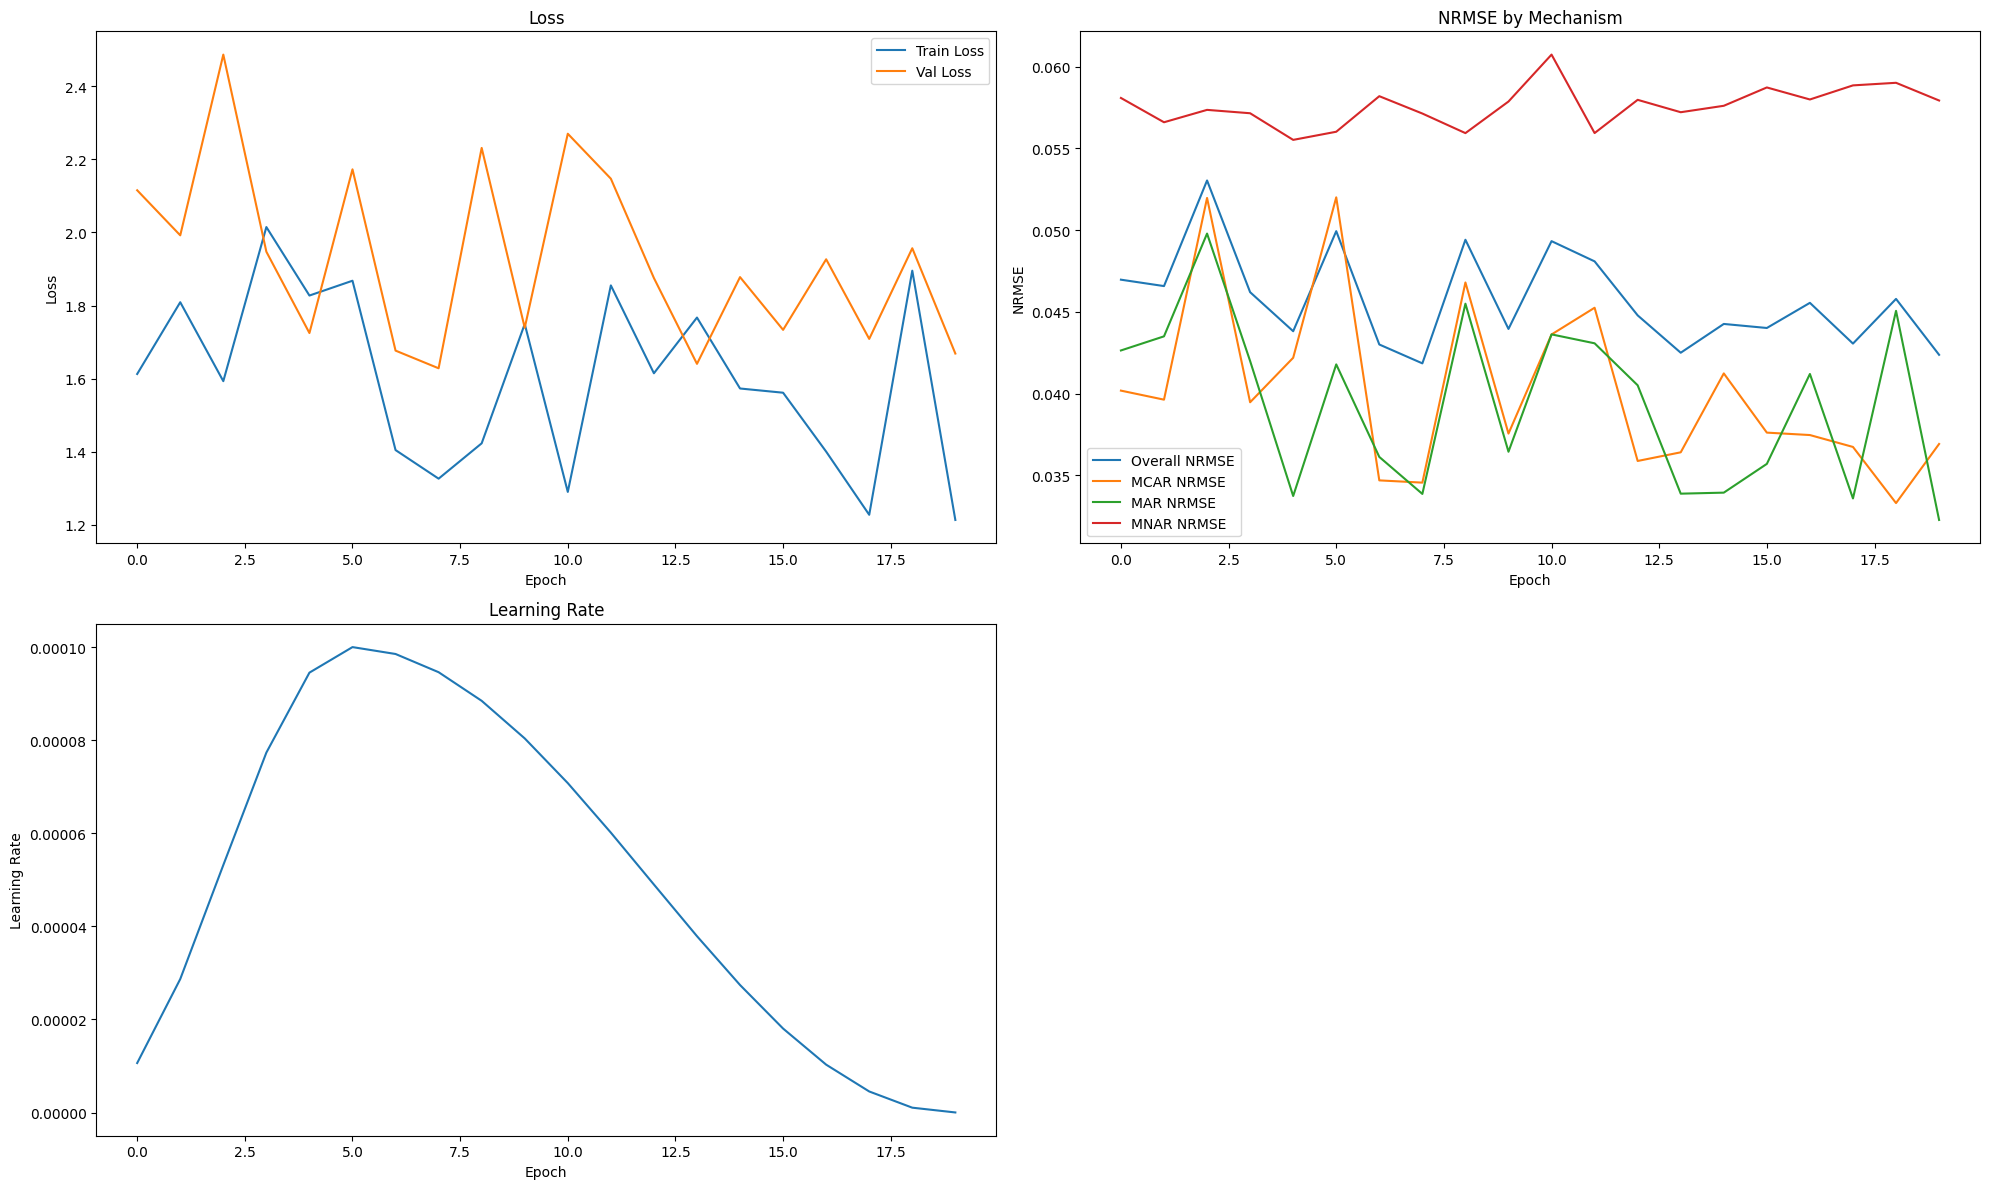


=== Evaluating on Test Set ===
Test metrics:
  Overall NRMSE: 0.0581
  MCAR NRMSE: 0.0496
  MAR NRMSE: 0.0572
  MNAR NRMSE: 0.0675

=== Saving Models ===
Training complete! All models and results saved in: models\2025-04-15_21-33-10_model-ensemble+5Fold


In [25]:
# Main execution code
if __name__ == "__main__":
    # Configuration
    config = {
        # Data parameters
        "data_path": "./data/physionet_39_features_only_no_leakage.csv",
        "test_size": 0.2,
        "val_size": 0.1,
        
        # Model parameters
        "d_model": 384,              
        "num_heads": 12,             
        "num_layers": 6,            
        "dim_feedforward": 1536,    
        "dropout": 0.15,             
        "activation": "gelu",
        
        # Training parameters
        "batch_size": 128,          
        "learning_rate": 0.0001,     
        "weight_decay": 0.005,       
        "num_epochs": 20,           
        "patience": 25,              
        "missing_fraction": 0.3,
        
        "warmup_steps_pct": 0.2,     # Shorter warmup phase
        "min_lr_factor": 5000.0,     # Slower final decay
        
        # Save parameters
        "save_dir": "models"
    }
    
    # Create directories with timestamp
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_dir = os.path.join(config["save_dir"], f"{current_time}_model-ensemble+5Fold")
    os.makedirs(save_dir, exist_ok=True)
    
    # Create experiment log file
    experiment_log = os.path.join(save_dir, "experiment_log.txt")
    with open(experiment_log, "w") as f:
        f.write(f"Experiment started at: {current_time}\n")
        f.write("Configuration:\n")
        for key, value in config.items():
            f.write(f"  {key}: {value}\n")
    
    # Load and prepare data
    train_data, val_data, test_data, scaler, column_indices = load_and_prepare_data(
        config["data_path"],
        config["test_size"],
        config["val_size"]
    )
    
    # Add flag to control whether to run k-fold validation
    RUN_KFOLD = True
    
    if RUN_KFOLD:
        print("\n=== Running K-Fold Cross-Validation ===")
        # Combine train and validation data for k-fold
        combined_data = torch.cat([train_data, val_data], dim=0)
        
        # Set a smaller number of epochs for k-fold to save time
        kfold_config = config.copy()
        kfold_config["num_epochs"] = 100  # Reduced epochs for k-fold
        
        # Run k-fold validation with single model
        print("\n---- K-Fold with Single Model ----")
        cv_metrics_single, _ = cross_validate_model(
            combined_data, 
            column_indices, 
            kfold_config, 
            n_folds=5,
            model_type="single"
        )
        
        # Run k-fold validation with ensemble model
        print("\n---- K-Fold with Ensemble Model ----")
        cv_metrics_ensemble, _ = cross_validate_model(
            combined_data, 
            column_indices, 
            kfold_config, 
            n_folds=3,  # Fewer folds for ensemble to save time
            model_type="ensemble"
        )
        
        # Save cross-validation results
        cv_results_path = os.path.join(save_dir, "cv_results.txt")
        with open(cv_results_path, "w") as f:
            f.write("Single Model Cross-Validation Results:\n")
            f.write(f"  NRMSE: {cv_metrics_single['nrmse']:.4f} ± {cv_metrics_single['nrmse_std']:.4f}\n")
            f.write(f"  MCAR NRMSE: {cv_metrics_single['mcar_nrmse']:.4f} ± {cv_metrics_single['mcar_nrmse_std']:.4f}\n")
            f.write(f"  MAR NRMSE: {cv_metrics_single['mar_nrmse']:.4f} ± {cv_metrics_single['mar_nrmse_std']:.4f}\n")
            f.write(f"  MNAR NRMSE: {cv_metrics_single['mnar_nrmse']:.4f} ± {cv_metrics_single['mnar_nrmse_std']:.4f}\n\n")
            
            f.write("Ensemble Model Cross-Validation Results:\n")
            f.write(f"  NRMSE: {cv_metrics_ensemble['nrmse']:.4f} ± {cv_metrics_ensemble['nrmse_std']:.4f}\n")
            f.write(f"  MCAR NRMSE: {cv_metrics_ensemble['mcar_nrmse']:.4f} ± {cv_metrics_ensemble['mcar_nrmse_std']:.4f}\n")
            f.write(f"  MAR NRMSE: {cv_metrics_ensemble['mar_nrmse']:.4f} ± {cv_metrics_ensemble['mar_nrmse_std']:.4f}\n")
            f.write(f"  MNAR NRMSE: {cv_metrics_ensemble['mnar_nrmse']:.4f} ± {cv_metrics_ensemble['mnar_nrmse_std']:.4f}\n")
    
    # Choose model type based on cross-validation results (if performed)
    if RUN_KFOLD and cv_metrics_ensemble['nrmse'] < cv_metrics_single['nrmse']:
        print("\nEnsemble model performed better in cross-validation. Using ensemble for final model.")
        final_model_type = "ensemble"
    else:
        print("\nUsing single model for final training.")
        final_model_type = "single"
    
    # Train final model on the entire training set
    print("\n=== Training Final Model ===")
    model, history = train_model(train_data, val_data, column_indices, config, model_type=final_model_type)
    
    # Plot training history
    plot_training_history(history, os.path.join(save_dir, "training_history.png"))
    

    # Evaluate on test set
    print("\n=== Evaluating on Test Set ===")
    test_dataloader = DataLoader(TensorDataset(test_data), batch_size=config["batch_size"])
    test_metrics = validate(model, test_dataloader, config["missing_fraction"], ["MCAR", "MAR", "MNAR"])
    
    print(f"Test metrics:")
    print(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}")
    print(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}")
    print(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}")
    print(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
    
    
    
    # Save test results
    test_results_path = os.path.join(save_dir, "test_results.txt")
    with open(test_results_path, "w") as f:
        f.write("Test Results:\n")
        f.write(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}\n")
        f.write(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}\n")
        f.write(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}\n")
        f.write(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}\n")
    
    # Save models
    print(f"\n=== Saving Models ===")
    
    # Save final model
    model_save_path = os.path.join(save_dir, "final_model.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config,
        "model_type": final_model_type
    }, model_save_path)
    
    # Save scaler
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    # Update experiment log
    with open(experiment_log, "a") as f:
        f.write("\nFinal Test Results:\n")
        f.write(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}\n")
        f.write(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}\n")
        f.write(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}\n")
        f.write(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}\n")
        
        f.write(f"\nExperiment completed at: {datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")

    print(f"Training complete! All models and results saved in: {save_dir}")



## Model testing

In [26]:
def evaluate_imputation_performance(model, test_data, column_indices, missing_percentages=[0.1, 0.2, 0.3, 0.4, 0.5], 
                                    mechanisms=["MCAR", "MAR", "MNAR"]):
    """
    Evaluate the model's imputation performance across different missing percentages and mechanisms.
    
    Args:
        model (nn.Module): Trained model
        test_data (torch.Tensor): Test data tensor
        column_indices (torch.Tensor): Column indices
        missing_percentages (list): List of missing data percentages to evaluate
        mechanisms (list): List of missing data mechanisms to evaluate
        
    Returns:
        pd.DataFrame: DataFrame with NRMSE results for each mechanism and percentage
    """
    model.eval()
    results = {}
    
    with torch.no_grad():
        for mechanism in mechanisms:
            mechanism_results = []
            
            for missing_pct in missing_percentages:
                batch_size = 128
                total_nrmse = 0
                num_batches = 0
                
                # Create DataLoader for test data
                test_dataloader = DataLoader(TensorDataset(test_data), batch_size=batch_size)
                
                for batch in tqdm(test_dataloader, desc=f"Evaluating {mechanism} at {missing_pct*100}%"):
                    x = batch[0].to(device)
                    
                    # Create a mask for missing values
                    mask = create_missing_mask(x, missing_pct, mechanism)
                    
                    # Create input with missing values set to 0
                    x_masked = x.clone()
                    x_masked[mask == 1] = 0
                    
                    # Forward pass
                    predictions = model(x_masked, column_indices, mask)
                    
                    # Compute NRMSE
                    nrmse = compute_nrmse(predictions, x, mask)
                    total_nrmse += nrmse
                    num_batches += 1
                
                avg_nrmse = total_nrmse / num_batches
                mechanism_results.append(avg_nrmse)
                print(f"{mechanism} at {missing_pct*100}% missing: NRMSE = {avg_nrmse:.4f}")
            
            results[mechanism] = mechanism_results
    
    # Create a DataFrame for visualization
    results_df = pd.DataFrame(results, index=[f"{int(pct*100)}%" for pct in missing_percentages])
    results_df.index.name = "Missing Percentage"
    
    return results_df

In [27]:
def visualize_imputation_performance(results_df, save_path=None):
    """
    Create visualizations for imputation performance.
    
    Args:
        results_df (pd.DataFrame): DataFrame with NRMSE results
        save_path (str, optional): Path to save the figures
    """
    # 1. Create a heatmap visualization
    plt.figure(figsize=(10, 6))
    
    # Create a heatmap with custom colormap (lower values = better = greener)
    sns.heatmap(results_df, annot=True, cmap="RdYlGn_r", fmt=".4f", 
                linewidths=.5, cbar_kws={'label': 'NRMSE (lower is better)'})
    
    plt.title("Imputation Performance (NRMSE) by Missing Mechanism and Percentage")
    plt.tight_layout()
    
    if save_path:
        heatmap_path = save_path.replace(".png", "_heatmap.png")
        plt.savefig(heatmap_path)
        print(f"Heatmap saved to {heatmap_path}")
    
    plt.show()
    
    # 2. Create a line plot
    plt.figure(figsize=(12, 6))
    
    # Convert index to numeric for plotting
    results_df_plot = results_df.copy()
    results_df_plot.index = [int(idx.replace("%", "")) for idx in results_df_plot.index]
    
    # Plot lines for each mechanism
    for column in results_df_plot.columns:
        plt.plot(results_df_plot.index, results_df_plot[column], marker='o', linewidth=2, label=column)
    
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("NRMSE (lower is better)")
    plt.title("Imputation Performance Across Missing Percentages")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(results_df_plot.index)
    
    if save_path:
        line_path = save_path.replace(".png", "_lineplot.png")
        plt.savefig(line_path)
        print(f"Line plot saved to {line_path}")
    
    plt.show()
    
    # 3. Create a bar chart comparison
    plt.figure(figsize=(12, 6))
    
    # Plot grouped bars
    bar_width = 0.25
    r = np.arange(len(results_df_plot.index))
    
    # Plot bars for each mechanism
    for i, column in enumerate(results_df_plot.columns):
        plt.bar(r + i*bar_width, results_df_plot[column], width=bar_width, label=column)
    
    # Add labels and legend
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("NRMSE (lower is better)")
    plt.title("Imputation Performance by Missing Mechanism and Percentage")
    plt.xticks(r + bar_width, results_df_plot.index)
    plt.legend()
    
    if save_path:
        bar_path = save_path.replace(".png", "_barchart.png")
        plt.savefig(bar_path)
        print(f"Bar chart saved to {bar_path}")
    
    plt.show()
    
    # 4. Create a table visualization
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('off')
    ax.axis('tight')
    
    # Create a table with colored cells based on values
    # First, normalize the data for coloring
    norm_data = results_df.copy()
    for col in norm_data.columns:
        max_val = norm_data[col].max()
        min_val = norm_data[col].min()
        if max_val > min_val:
            norm_data[col] = (norm_data[col] - min_val) / (max_val - min_val)
        else:
            norm_data[col] = 0
    
    # Create a table with cell colors
    cell_colors = plt.cm.RdYlGn_r(norm_data.values)
    table = ax.table(cellText=results_df.values.round(4), 
                    rowLabels=results_df.index,
                    colLabels=results_df.columns,
                    cellColours=cell_colors,
                    loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    
    plt.title("NRMSE Values by Missing Mechanism and Percentage", y=0.8)
    
    if save_path:
        table_path = save_path.replace(".png", "_table.png")
        plt.savefig(table_path, bbox_inches='tight')
        print(f"Table visualization saved to {table_path}")
    
    plt.show()
    
    return results_df


=== Evaluating Imputation Performance Across Missing Percentages ===


Evaluating MCAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 33.90it/s]


MCAR at 10.0% missing: NRMSE = 0.0511


Evaluating MCAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 34.51it/s]


MCAR at 20.0% missing: NRMSE = 0.0493


Evaluating MCAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 34.26it/s]


MCAR at 30.0% missing: NRMSE = 0.0510


Evaluating MCAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 34.64it/s]


MCAR at 40.0% missing: NRMSE = 0.0530


Evaluating MCAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 34.45it/s]


MCAR at 50.0% missing: NRMSE = 0.0497


Evaluating MAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 23.20it/s]


MAR at 10.0% missing: NRMSE = 0.0377


Evaluating MAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 22.51it/s]


MAR at 20.0% missing: NRMSE = 0.0580


Evaluating MAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 22.76it/s]


MAR at 30.0% missing: NRMSE = 0.0522


Evaluating MAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 23.24it/s]


MAR at 40.0% missing: NRMSE = 0.0561


Evaluating MAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 22.33it/s]


MAR at 50.0% missing: NRMSE = 0.0517


Evaluating MNAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 23.41it/s]


MNAR at 10.0% missing: NRMSE = 0.0711


Evaluating MNAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 23.26it/s]


MNAR at 20.0% missing: NRMSE = 0.0755


Evaluating MNAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 22.73it/s]


MNAR at 30.0% missing: NRMSE = 0.0666


Evaluating MNAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 22.09it/s]


MNAR at 40.0% missing: NRMSE = 0.0627


Evaluating MNAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 23.36it/s]


MNAR at 50.0% missing: NRMSE = 0.0585
Raw imputation results saved to models\2025-04-15_21-33-10_model-ensemble+5Fold\imputation_performance\imputation_results.csv
Heatmap saved to models\2025-04-15_21-33-10_model-ensemble+5Fold\imputation_performance\imputation_performance_heatmap.png


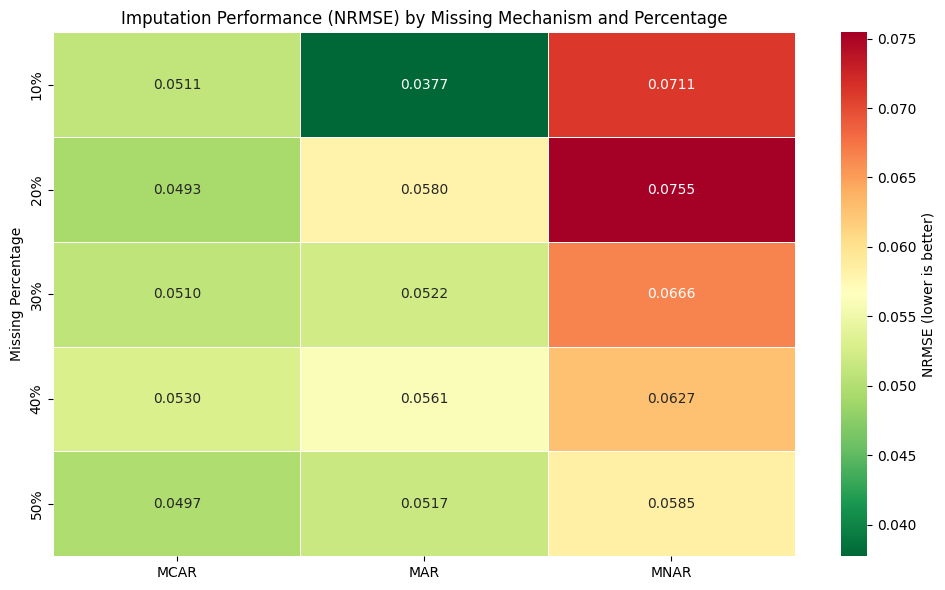

Line plot saved to models\2025-04-15_21-33-10_model-ensemble+5Fold\imputation_performance\imputation_performance_lineplot.png


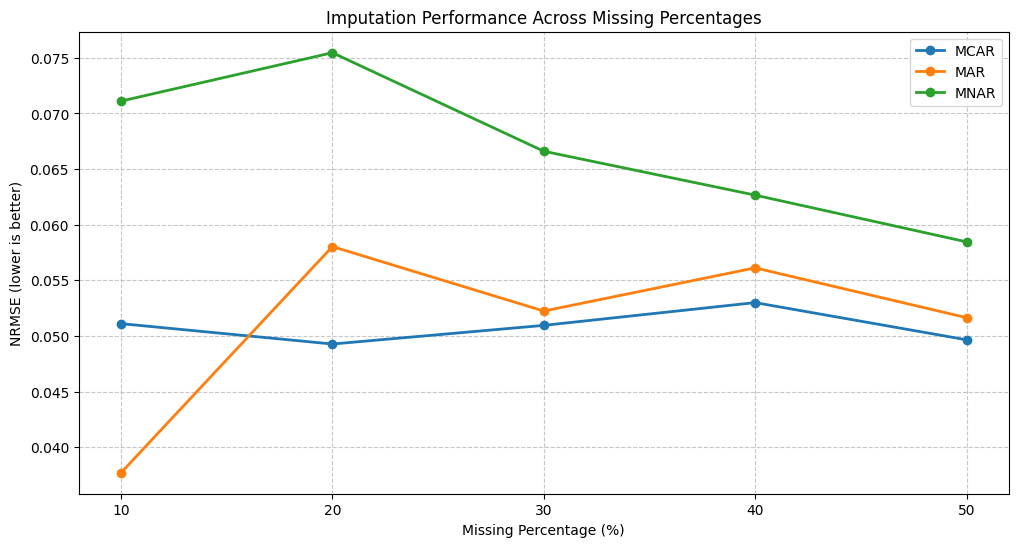

Bar chart saved to models\2025-04-15_21-33-10_model-ensemble+5Fold\imputation_performance\imputation_performance_barchart.png


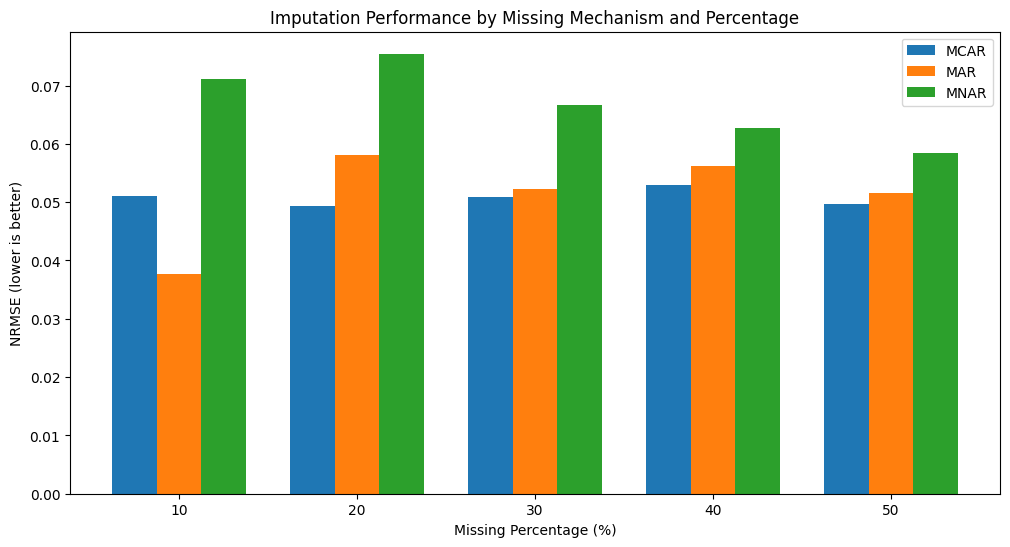

Table visualization saved to models\2025-04-15_21-33-10_model-ensemble+5Fold\imputation_performance\imputation_performance_table.png


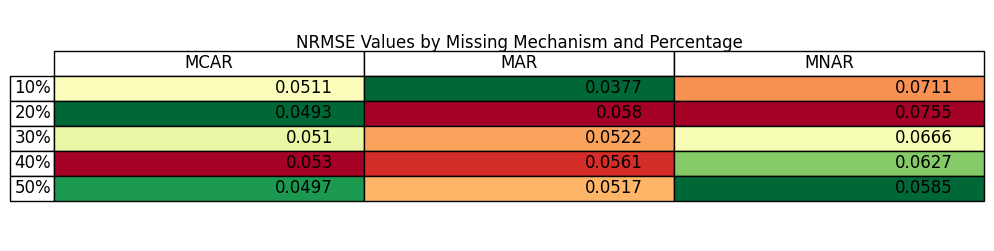


Imputation performance evaluation complete!


In [28]:
if __name__ == "__main__":
    # Create a section for imputation performance evaluation
    print("\n=== Evaluating Imputation Performance Across Missing Percentages ===")
    
    # Define the missing percentages to evaluate
    missing_percentages = [0.1, 0.2, 0.3, 0.4, 0.5]
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Create a directory for imputation performance visualizations
    imputation_dir = os.path.join(save_dir, "imputation_performance")
    os.makedirs(imputation_dir, exist_ok=True)
    
    # Evaluate imputation performance
    results_df = evaluate_imputation_performance(
        model,                    # Use the final trained model
        test_data,                # Test data
        column_indices,           # Column indices
        missing_percentages,      # Missing percentages
        mechanisms                # Missing mechanisms
    )
    
    # Save the raw results to CSV
    results_csv_path = os.path.join(imputation_dir, "imputation_results.csv")
    results_df.to_csv(results_csv_path)
    print(f"Raw imputation results saved to {results_csv_path}")
    
    # Create and save visualizations
    visualize_imputation_performance(
        results_df,
        save_path=os.path.join(imputation_dir, "imputation_performance.png")
    )
        
    print("\nImputation performance evaluation complete!")

## Impute the original dataset

In [29]:
def impute_original_dataset(trained_model, scaler, save_path="imputed_original.csv"):
    """
    Load the original CSV dataset, impute missing values using the pre-trained transformer model,
    and save the imputed dataset.
    
    Args:
        trained_model: The pre-trained imputation model
        scaler: The fitted scaler used during model training
        save_path: Path to save the imputed dataset
    """
    print("\n=== Imputing Original Dataset ===")
    
    # Set model to evaluation mode
    trained_model.eval()
    
    # File path
    original_file_path = "./data/physionet_39_features_only_no_leakage.csv"
    
    # Load the original dataset
    print(f"Loading original dataset from {original_file_path}...")
    df_original = pd.read_csv(original_file_path, index_col=None)
    print(f"Original dataset shape: {df_original.shape}")
    
    # Check for missing values
    missing_count = df_original.isna().sum().sum()
    missing_percentage = (missing_count / (df_original.shape[0] * df_original.shape[1])) * 100
    print(f"Dataset contains {missing_count} missing values ({missing_percentage:.2f}% of all values)")
    
    # Create a copy of the original dataset for imputation
    df_imputed = df_original.copy()
    
    # Extract numerical columns for imputation
    numerical_cols = df_original.select_dtypes(include=['number']).columns
    print(f"Found {len(numerical_cols)} numerical columns")
    
    # Create mask for missing values (True where values are missing)
    missing_mask = df_original[numerical_cols].isna()
    
    # Fill missing values with 0 for initial processing
    df_filled = df_original[numerical_cols].fillna(0)
    
    # Scale the data using the provided scaler
    data_scaled = scaler.transform(df_filled)
    
    # Convert to PyTorch tensor
    data_tensor = torch.tensor(data_scaled, dtype=torch.float32).to(device)
    
    # Create column indices tensor
    column_indices = torch.arange(data_tensor.shape[1]).to(device)
    
    # Create mask tensor (1 where values are missing, 0 otherwise)
    mask_tensor = torch.tensor(missing_mask.values, dtype=torch.int).to(device)
    
    print("Performing imputation with trained model...")
    
    with torch.no_grad():
        # Get predictions from the model
        imputed_tensor = trained_model(data_tensor, column_indices, mask_tensor)
        
        # Convert to numpy for processing
        imputed_np = imputed_tensor.cpu().numpy()
        
        # Inverse transform to original scale
        imputed_np = scaler.inverse_transform(imputed_np)
        
        # Create a DataFrame from the imputed values
        imputed_df = pd.DataFrame(imputed_np, columns=numerical_cols, index=df_original.index)
        
        # Replace missing values in the original dataframe with imputed values
        for col in numerical_cols:
            if col in df_imputed.columns:
                missing_idx = df_imputed[col].isna()
                df_imputed.loc[missing_idx, col] = imputed_df.loc[missing_idx, col]
    
    # Save the imputed dataset
    print(f"Saving imputed dataset to {save_path}...")
    df_imputed.to_csv(save_path)
    
    # Verification
    missing_after = df_imputed[numerical_cols].isna().sum().sum()
    print(f"Missing values in numerical columns after imputation: {missing_after}")
    
    total_missing_after = df_imputed.isna().sum().sum()
    if total_missing_after > 0:
        print(f"Total missing values after imputation: {total_missing_after}")
        print("Note: Non-numerical columns may still contain missing values")
    else:
        print("All missing values have been successfully imputed")
    
    print("Imputation complete!")
    
    return df_imputed

In [ ]:
# Execute the imputation process
if __name__ == "__main__":
    print("\n=== Running Imputation on Original Dataset ===")
    
    # Use the already trained model
    # Assuming 'model' and 'scaler' are the trained model and scaler from earlier in the notebook
    imputed_data = impute_original_dataset(model, scaler, "imputed_original.csv")
    
    # Display sample of the imputed data
    print("\nSample of imputed data:")
    print(imputed_data.head())


=== Running Imputation on Original Dataset ===

=== Imputing Original Dataset ===
Loading original dataset from ./data/physionet_39_features_only_no_leakage.csv...
Original dataset shape: (2008, 39)
Dataset contains 3063 missing values (3.91% of all values)
Found 39 numerical columns
Performing imputation with trained model...


c:\Users\wh1sper\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Saving imputed dataset to imputed_original.csv...
Missing values in numerical columns after imputation: 0
All missing values have been successfully imputed
Imputation complete!

Sample of imputed data:
   verbal.response  eye.opening  movement  GCS  lactate.dehydrogenase  \
0                5            4         6   15             294.000000   
1                5            4         6   15             203.000000   
2                5            4         6   15             137.000000   
3                5            4         6   15             361.316101   
4                5            4         6   15             295.000000   

   glutamic.oxaloacetic.transaminase  globulin  total.bilirubin  \
0                          81.000000      23.8             18.3   
1                          21.000000      25.4             18.3   
2                           9.000000      27.7             11.9   
3                         166.699936      27.0             51.6   
4                       

: 